In [1]:
import os
import sys
import warnings

import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import ExtraTreesRegressor

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import generate_and_avaliate_model

from utils import location_station, find_set_sunrise, find_set_sunset, to_datetime
from utils import plot_sunrise_and_sunset
from utils import smooth_signal



%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise_update1.pkl')
df_station = pd.read_pickle('./data/df_station_sort_re.pkl')

In [3]:
df.head()

vtec   vtec_dt  vtec_dt2    gvtec1  gvtec1_dt  \
2013-12-01 03:30:00  33.624428 -0.428246 -0.020502 -3.216613   0.002355   
2013-12-01 03:40:00  33.205025 -0.546589 -0.118343 -3.122300   0.130198   
2013-12-01 03:50:00  32.539631 -0.772594 -0.226005 -2.810556   0.280756   
2013-12-01 04:00:00  31.469337 -1.082859 -0.310265 -2.320938   0.399753   
2013-12-01 04:10:00  29.995466 -1.429647 -0.346788 -1.764129   0.443303   

                        gvtec2  gvtec2_dt        s4  state_day  state_night  \
2013-12-01 03:30:00   1.826065   1.991653  0.163334        0.0          0.0   
2013-12-01 03:40:00   4.588494   2.530373  0.165397        0.0          0.0   
2013-12-01 03:50:00   7.786990   2.862830  0.168683        0.0          0.0   
2013-12-01 04:00:00  10.972091   2.894375  0.173552        0.0          0.0   
2013-12-01 04:10:00  13.734955   2.621609  0.178917        0.0          0.0   

                     state_dawn  state_day_shift  vm1  vd1  vm2  vd2  \
2013-12-01 03:30:00         1.0              NaN  NaN  NaN  NaN  NaN   
2013-12-01 03:40:00         1.0              0.0  NaN  NaN  NaN  NaN   
2013-12-01 03:50:00         1.0              0.0  NaN  NaN  NaN  NaN   
2013-12-01 04:00:00         1.0              0.0  NaN  NaN  NaN  NaN   
2013-12-01 04:10:00         1.0              0.0  NaN  NaN  NaN  NaN   

                     gvtec1_dt_lag_9  gvtec2_dt_lag_20  vtec_dt_lag_3  
2013-12-01 03:30:00              NaN               NaN            NaN  
2013-12-01 03:40:00              NaN               NaN            NaN  
2013-12-01 03:50:00              NaN               NaN            NaN  
2013-12-01 04:00:00              NaN               NaN      -2.155091  
2013-12-01 04:10:00              NaN               NaN      -3.209558

In [4]:
df_vtec = pd.DataFrame(index=df.index.values)

In [5]:
for i in range(0, 24):
    df_vtec['lag_'+str(i)] = df['vtec'].shift(i)
    
df_vtec['s4'] = df['s4']

df_vtec.to_pickle('./data/df_vtec_lags.pkl')

df.head()

vtec   vtec_dt  vtec_dt2    gvtec1  gvtec1_dt  \
2013-12-01 03:30:00  33.624428 -0.428246 -0.020502 -3.216613   0.002355   
2013-12-01 03:40:00  33.205025 -0.546589 -0.118343 -3.122300   0.130198   
2013-12-01 03:50:00  32.539631 -0.772594 -0.226005 -2.810556   0.280756   
2013-12-01 04:00:00  31.469337 -1.082859 -0.310265 -2.320938   0.399753   
2013-12-01 04:10:00  29.995466 -1.429647 -0.346788 -1.764129   0.443303   

                        gvtec2  gvtec2_dt        s4  state_day  state_night  \
2013-12-01 03:30:00   1.826065   1.991653  0.163334        0.0          0.0   
2013-12-01 03:40:00   4.588494   2.530373  0.165397        0.0          0.0   
2013-12-01 03:50:00   7.786990   2.862830  0.168683        0.0          0.0   
2013-12-01 04:00:00  10.972091   2.894375  0.173552        0.0          0.0   
2013-12-01 04:10:00  13.734955   2.621609  0.178917        0.0          0.0   

                     state_dawn  state_day_shift  vm1  vd1  vm2  vd2  \
2013-12-01 03:30:00         1.0              NaN  NaN  NaN  NaN  NaN   
2013-12-01 03:40:00         1.0              0.0  NaN  NaN  NaN  NaN   
2013-12-01 03:50:00         1.0              0.0  NaN  NaN  NaN  NaN   
2013-12-01 04:00:00         1.0              0.0  NaN  NaN  NaN  NaN   
2013-12-01 04:10:00         1.0              0.0  NaN  NaN  NaN  NaN   

                     gvtec1_dt_lag_9  gvtec2_dt_lag_20  vtec_dt_lag_3  
2013-12-01 03:30:00              NaN               NaN            NaN  
2013-12-01 03:40:00              NaN               NaN            NaN  
2013-12-01 03:50:00              NaN               NaN            NaN  
2013-12-01 04:00:00              NaN               NaN      -2.155091  
2013-12-01 04:10:00              NaN               NaN      -3.209558

In [6]:
df['vtec_i/vtec_i-1'] = df_vtec['lag_0']/df_vtec['lag_1']

In [7]:
for i in range(3, 15, 2):
    df['roti_'+str(i)] = df['vtec_dt'].rolling(i, center=True).std()

In [8]:
df.head()

vtec   vtec_dt  vtec_dt2    gvtec1  gvtec1_dt  \
2013-12-01 03:30:00  33.624428 -0.428246 -0.020502 -3.216613   0.002355   
2013-12-01 03:40:00  33.205025 -0.546589 -0.118343 -3.122300   0.130198   
2013-12-01 03:50:00  32.539631 -0.772594 -0.226005 -2.810556   0.280756   
2013-12-01 04:00:00  31.469337 -1.082859 -0.310265 -2.320938   0.399753   
2013-12-01 04:10:00  29.995466 -1.429647 -0.346788 -1.764129   0.443303   

                        gvtec2  gvtec2_dt        s4  state_day  state_night  \
2013-12-01 03:30:00   1.826065   1.991653  0.163334        0.0          0.0   
2013-12-01 03:40:00   4.588494   2.530373  0.165397        0.0          0.0   
2013-12-01 03:50:00   7.786990   2.862830  0.168683        0.0          0.0   
2013-12-01 04:00:00  10.972091   2.894375  0.173552        0.0          0.0   
2013-12-01 04:10:00  13.734955   2.621609  0.178917        0.0          0.0   

                      ...     gvtec1_dt_lag_9  gvtec2_dt_lag_20  \
2013-12-01 03:30:00   ...                 NaN               NaN   
2013-12-01 03:40:00   ...                 NaN               NaN   
2013-12-01 03:50:00   ...                 NaN               NaN   
2013-12-01 04:00:00   ...                 NaN               NaN   
2013-12-01 04:10:00   ...                 NaN               NaN   

                     vtec_dt_lag_3  vtec_i/vtec_i-1    roti_3    roti_5  \
2013-12-01 03:30:00            NaN              NaN       NaN       NaN   
2013-12-01 03:40:00            NaN         0.987527  0.174956       NaN   
2013-12-01 03:50:00            NaN         0.979961  0.269236  0.408081   
2013-12-01 04:00:00      -2.155091         0.967108  0.328696  0.485249   
2013-12-01 04:10:00      -3.209558         0.953165  0.332989  0.485184   

                       roti_7    roti_9  roti_11  roti_13  
2013-12-01 03:30:00       NaN       NaN      NaN      NaN  
2013-12-01 03:40:00       NaN       NaN      NaN      NaN  
2013-12-01 03:50:00       NaN       NaN      NaN      NaN  
2013-12-01 04:00:00  0.597261       NaN      NaN      NaN  
2013-12-01 04:10:00  0.587837  0.639111      NaN      NaN  

[5 rows x 26 columns]

In [9]:
df['gvtec1/gvtec2'] = df['gvtec1']/df['gvtec2']
df['gvtec1_dt/gvtec2_dt'] = df['gvtec1_dt']/df['gvtec2_dt']

In [10]:
df.to_pickle('./data/sj2_analise_update2.pkl')
df.to_csv('./data/sj2_analise_update2.csv')

In [11]:
list_day = []
list_second = []
for i in df.index.values:
    datetime_value = to_datetime(i)
    list_day.append(float(datetime_value.day))
    list_second.append(float(datetime_value.hour*3600+datetime_value.minute*60+datetime_value.second))

df['doy'] = list_day
df['ut'] = list_second

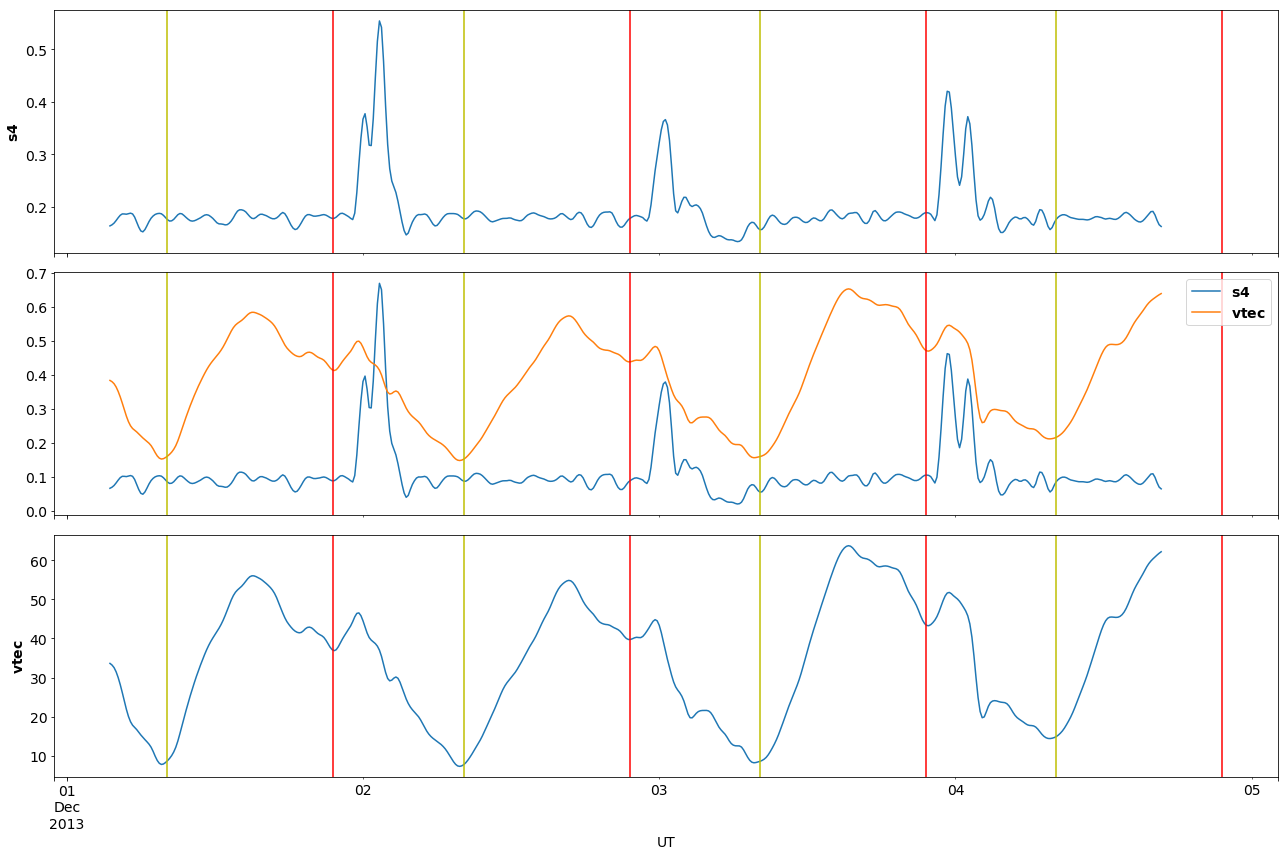

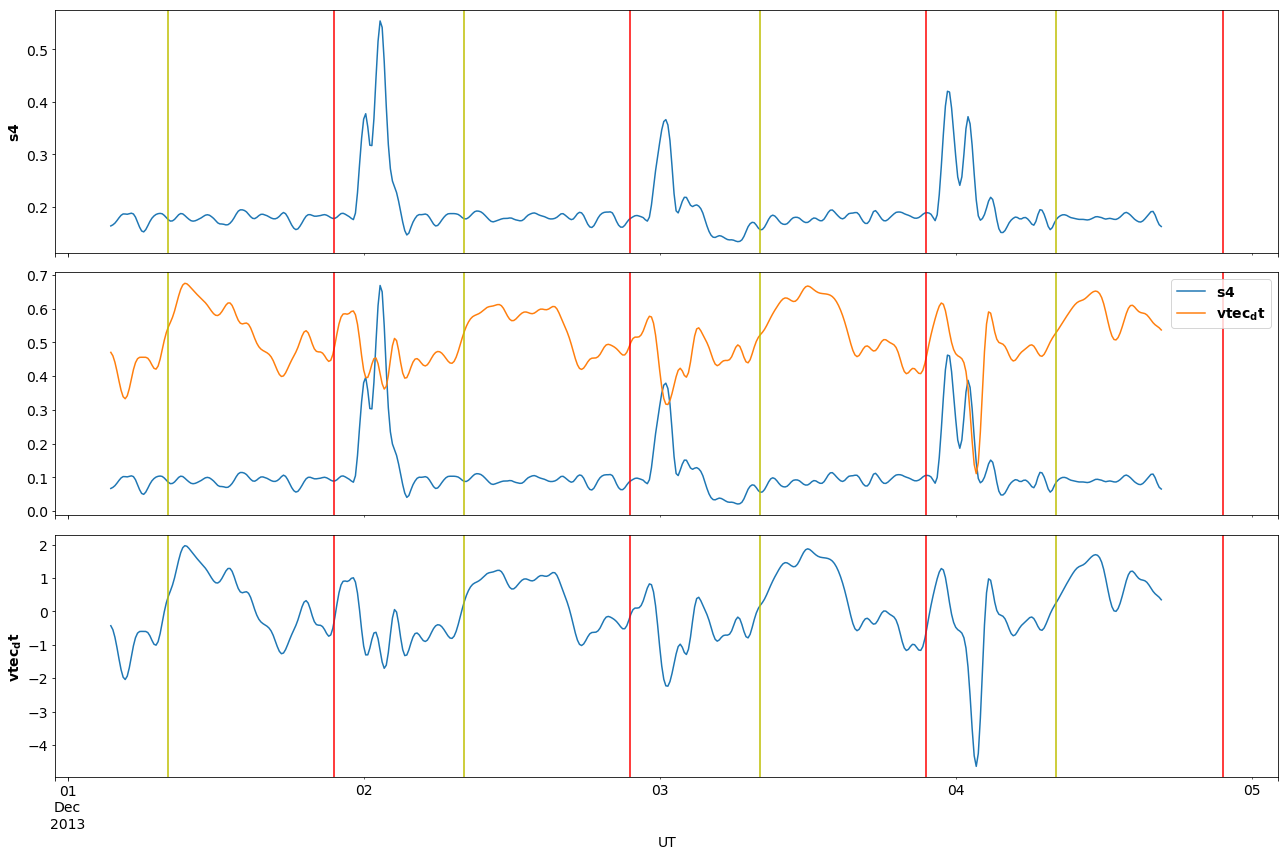

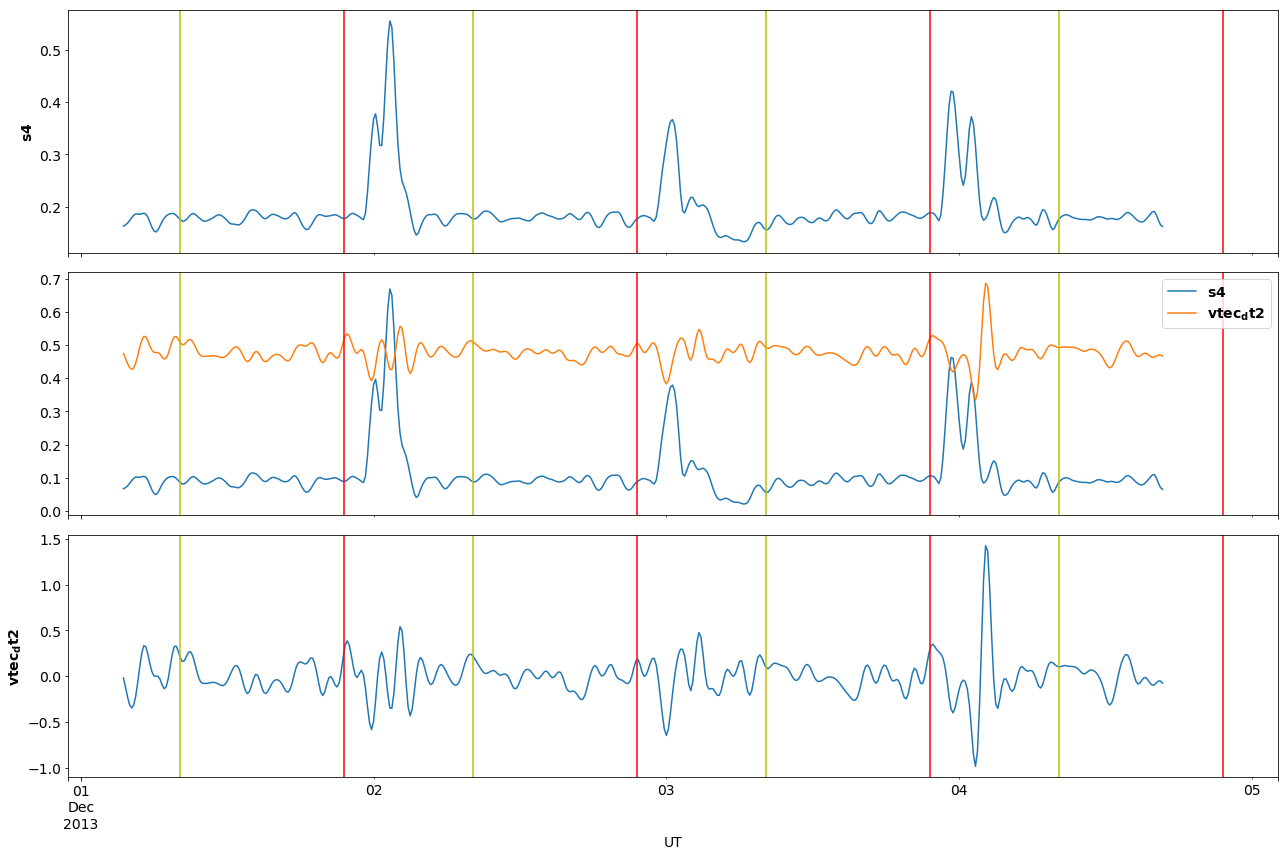

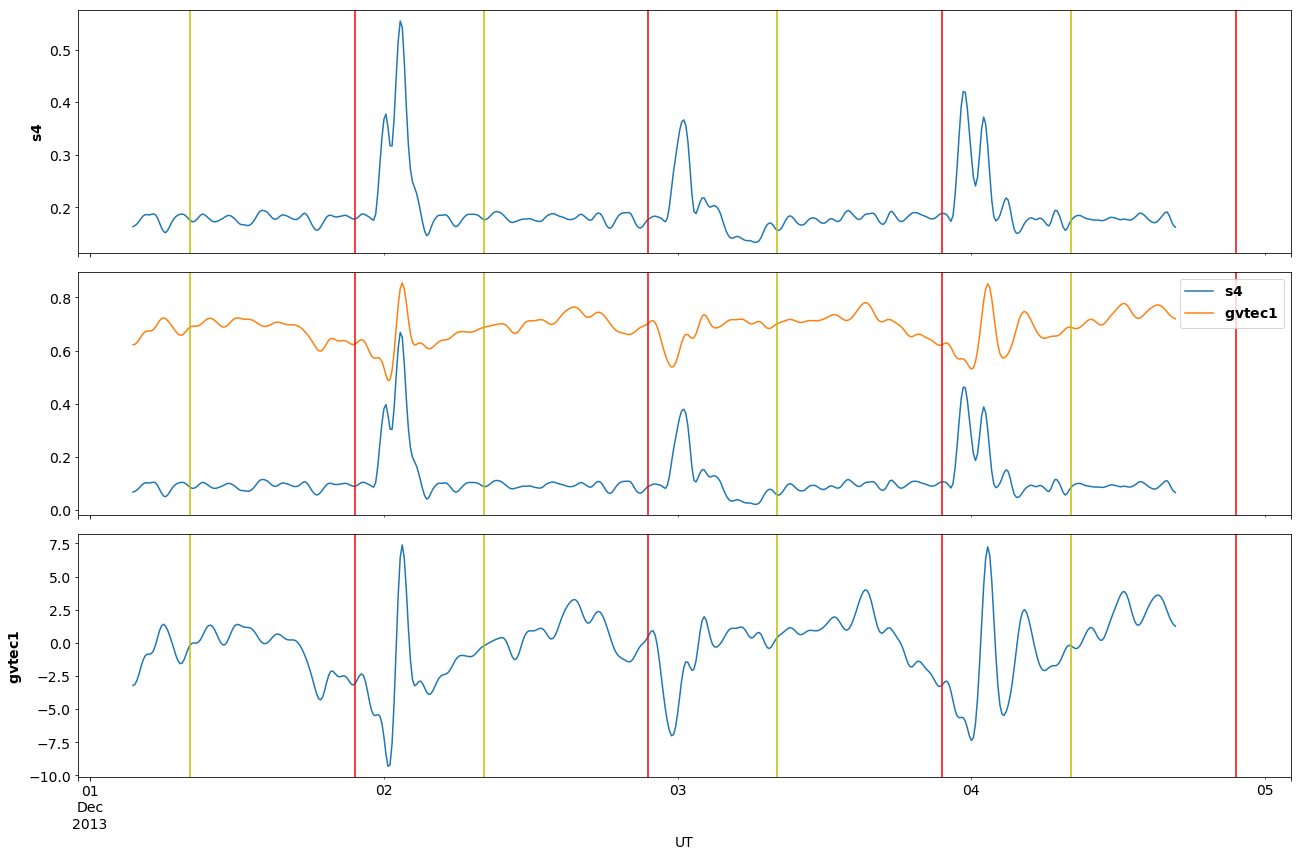

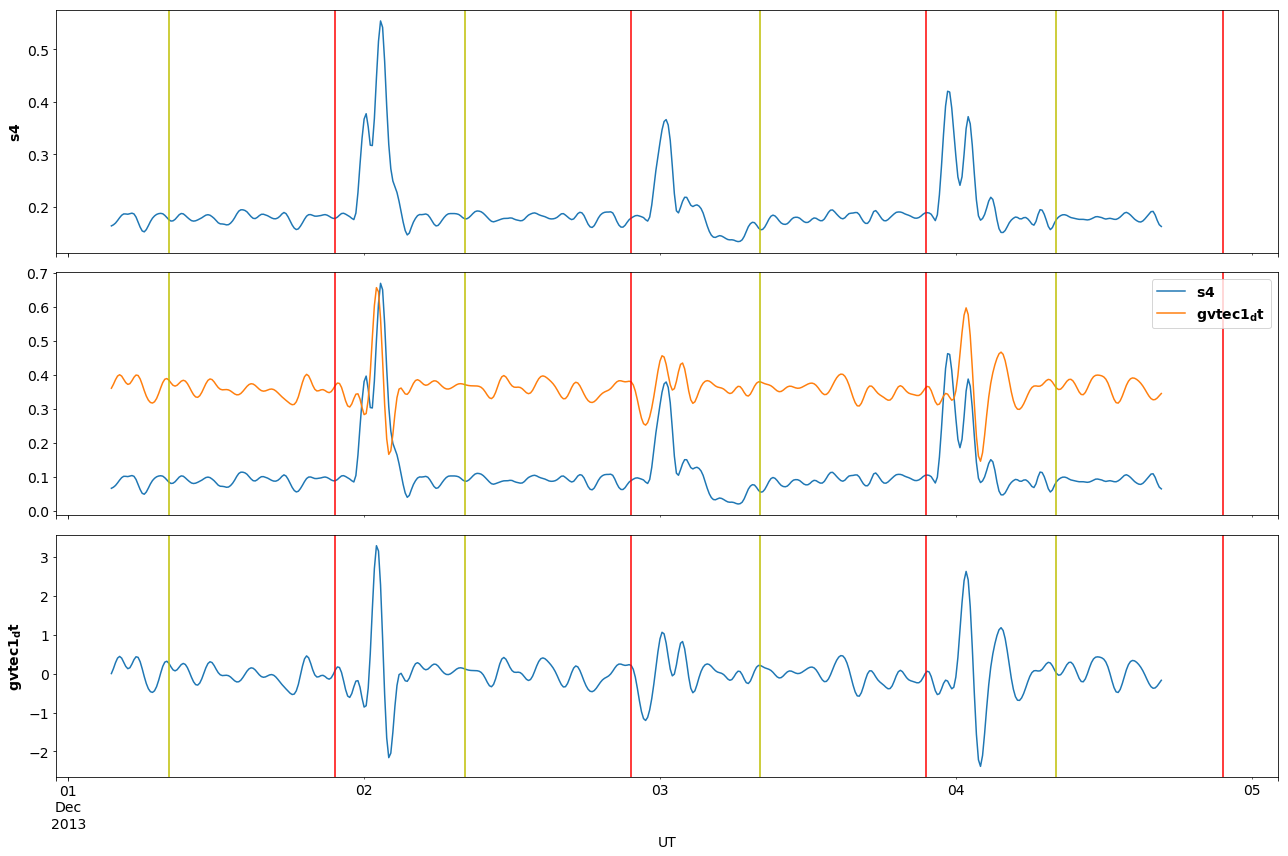

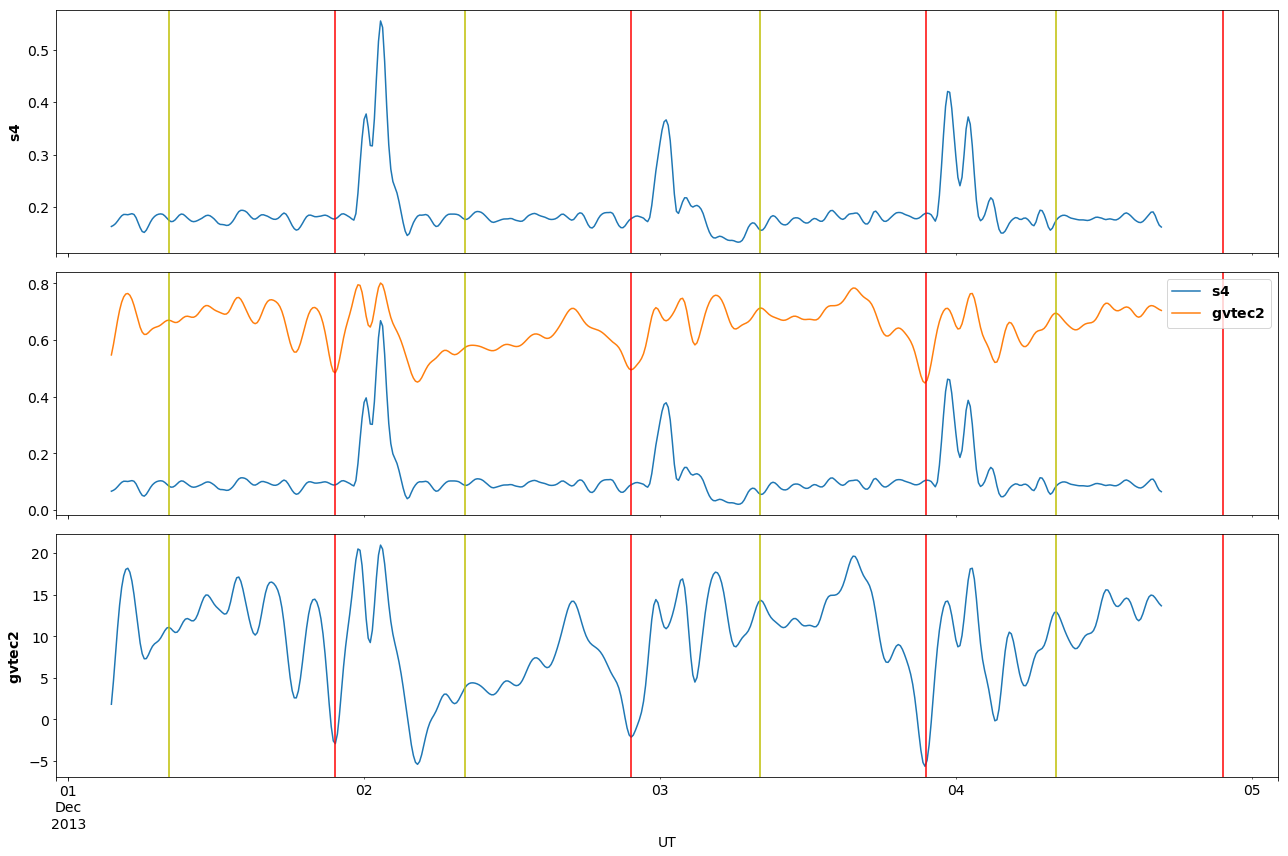

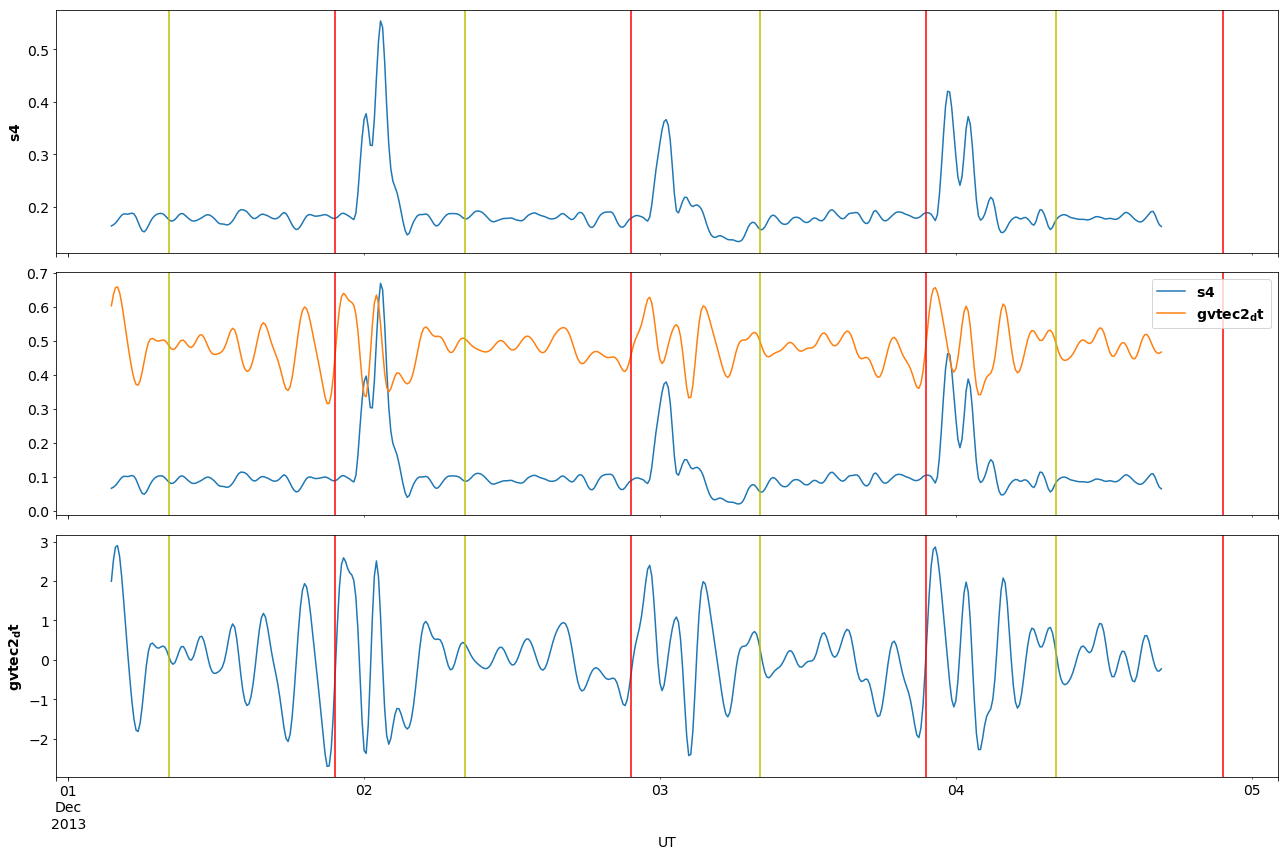

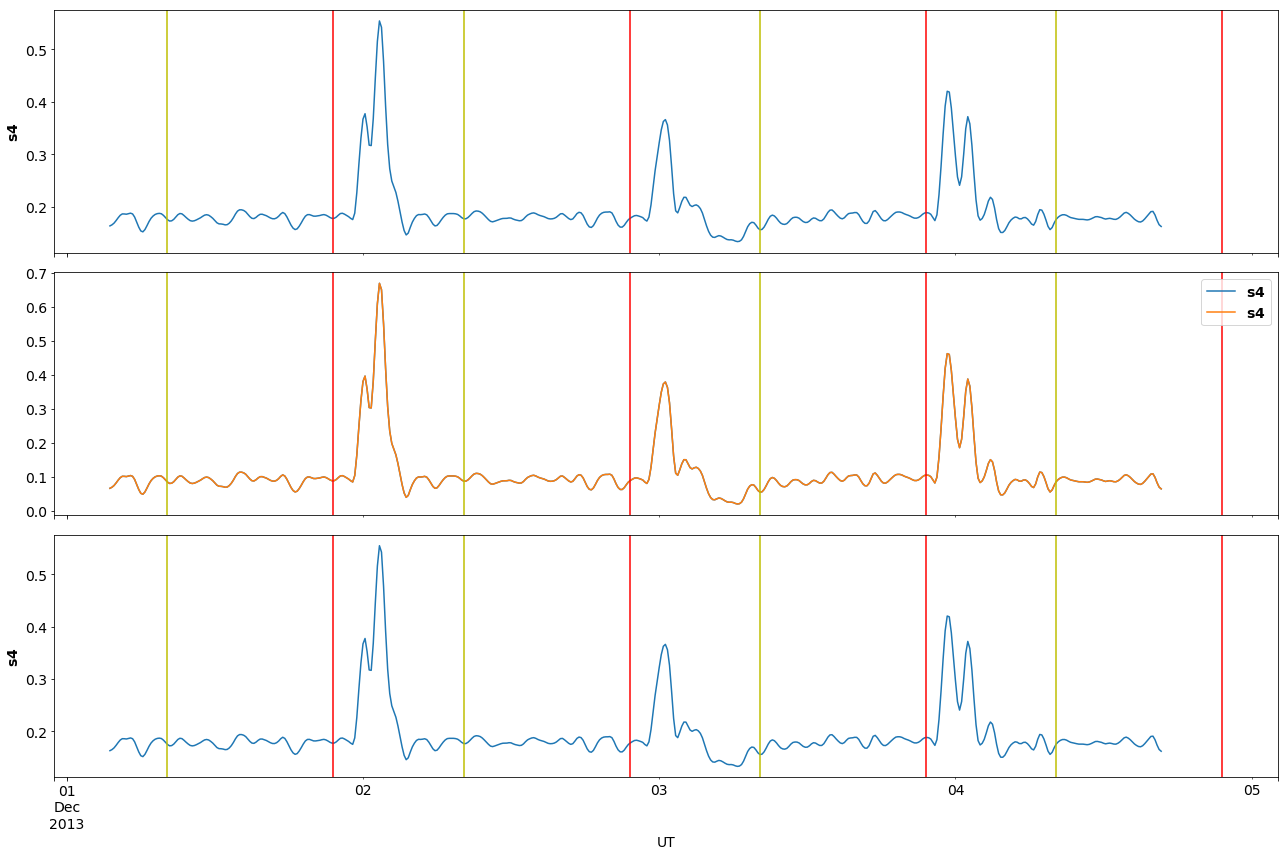

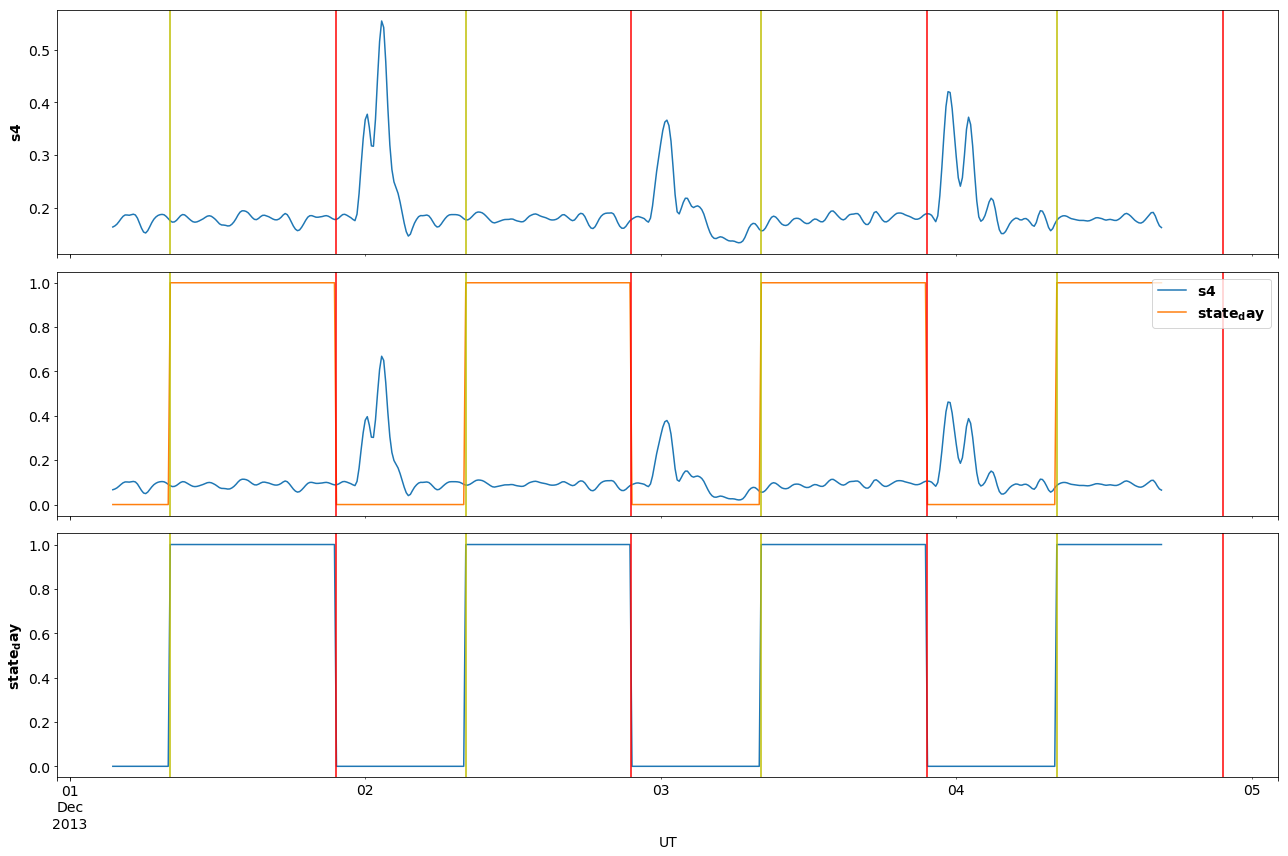

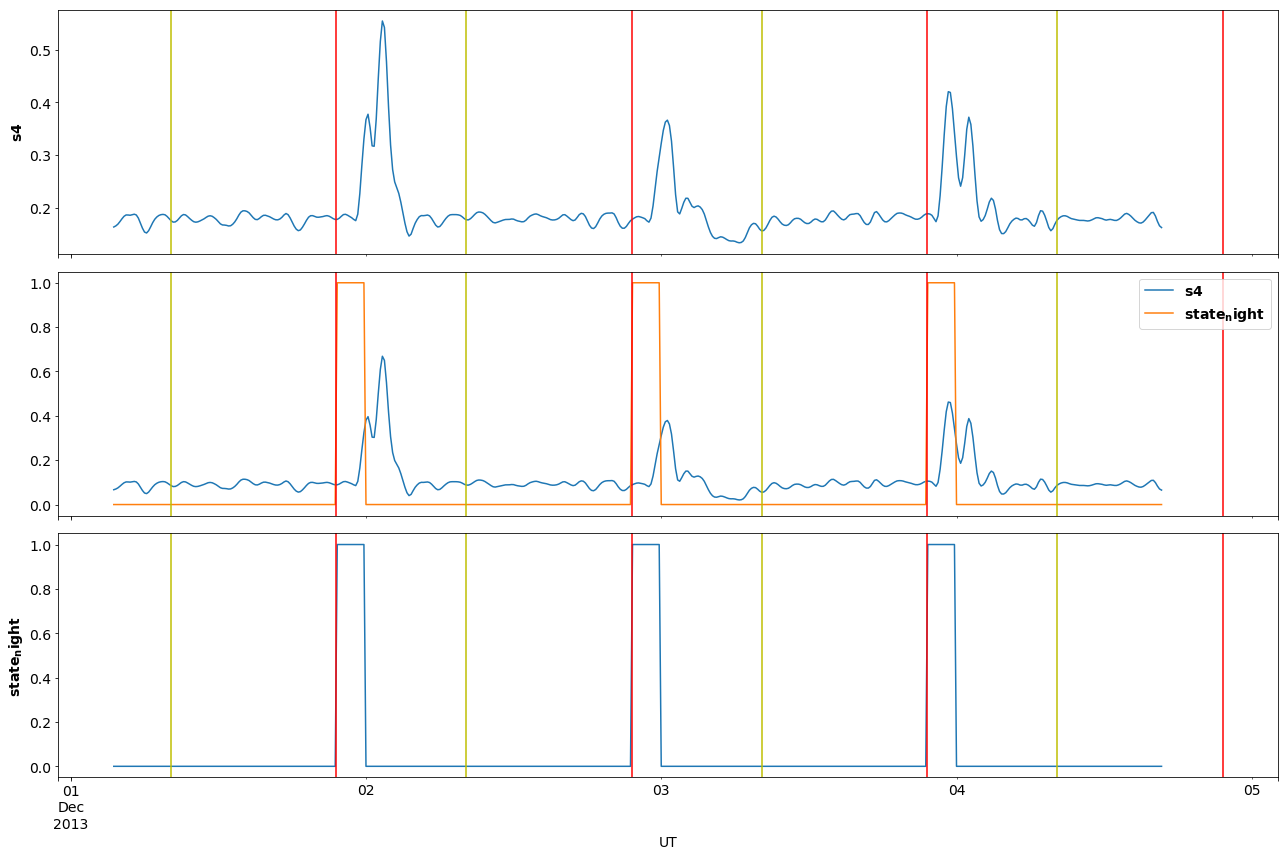

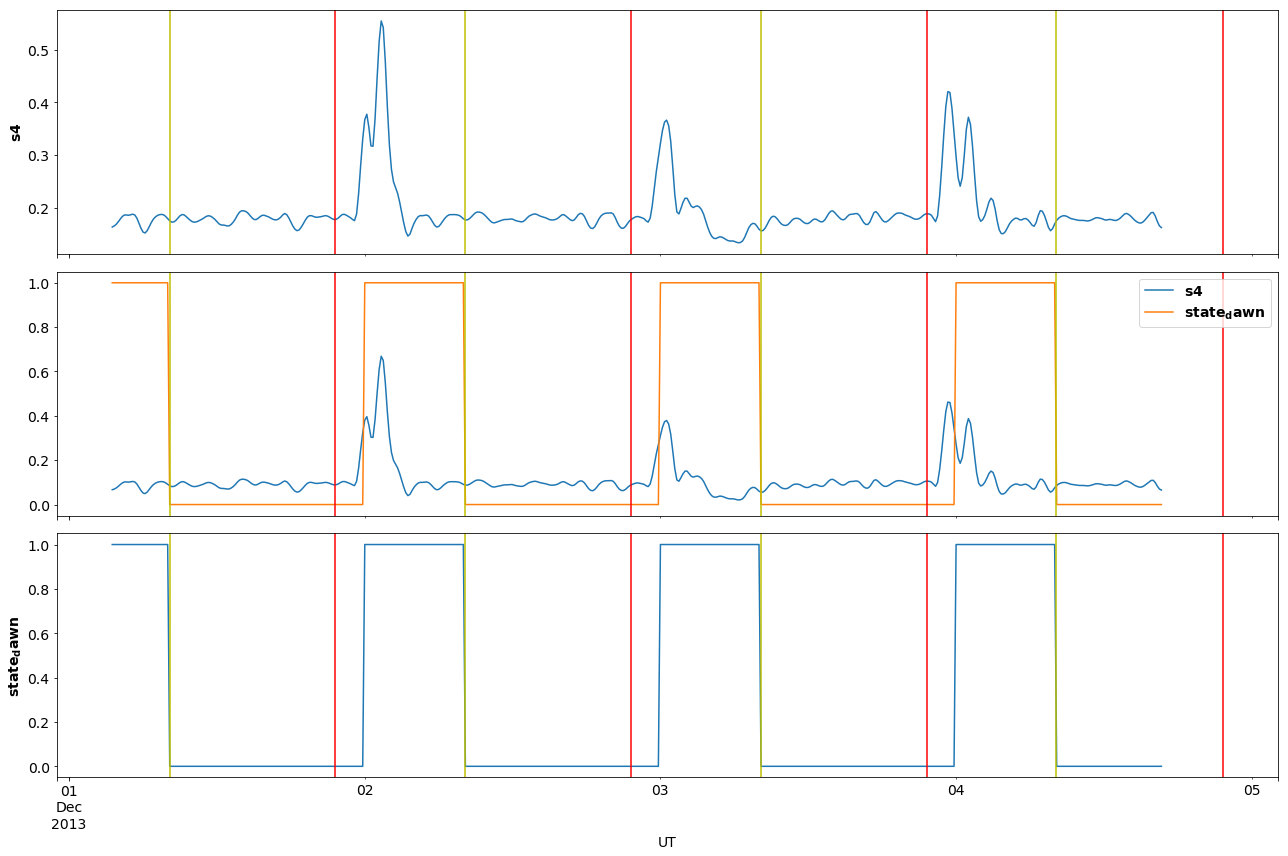

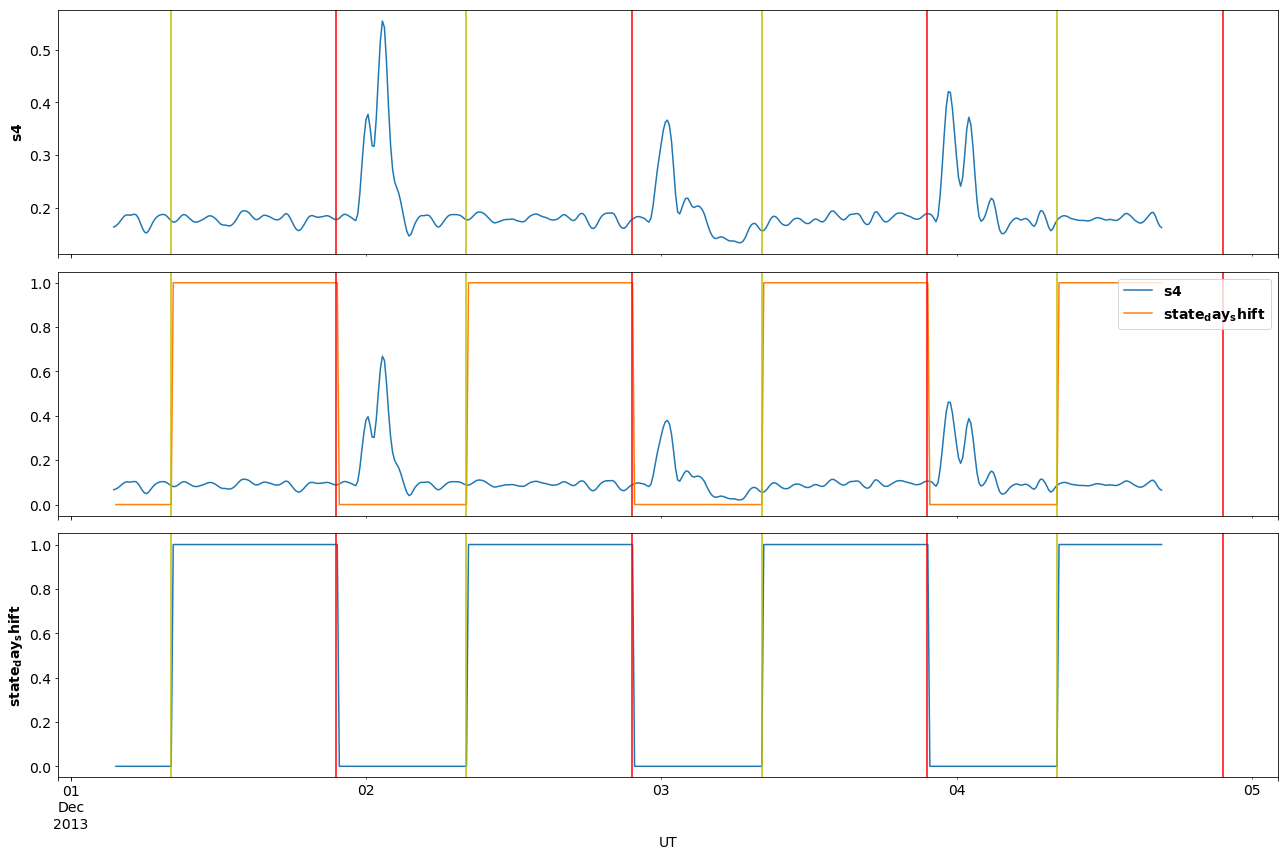

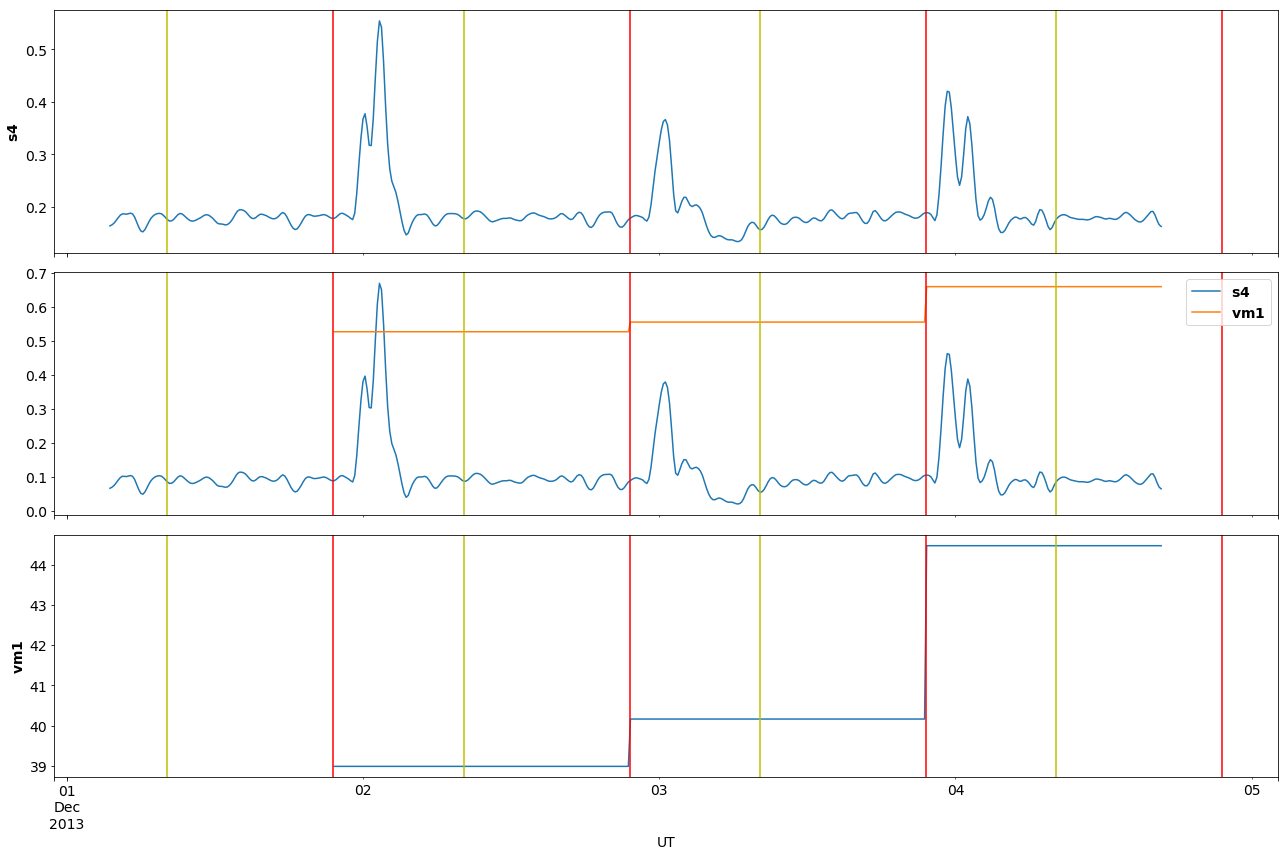

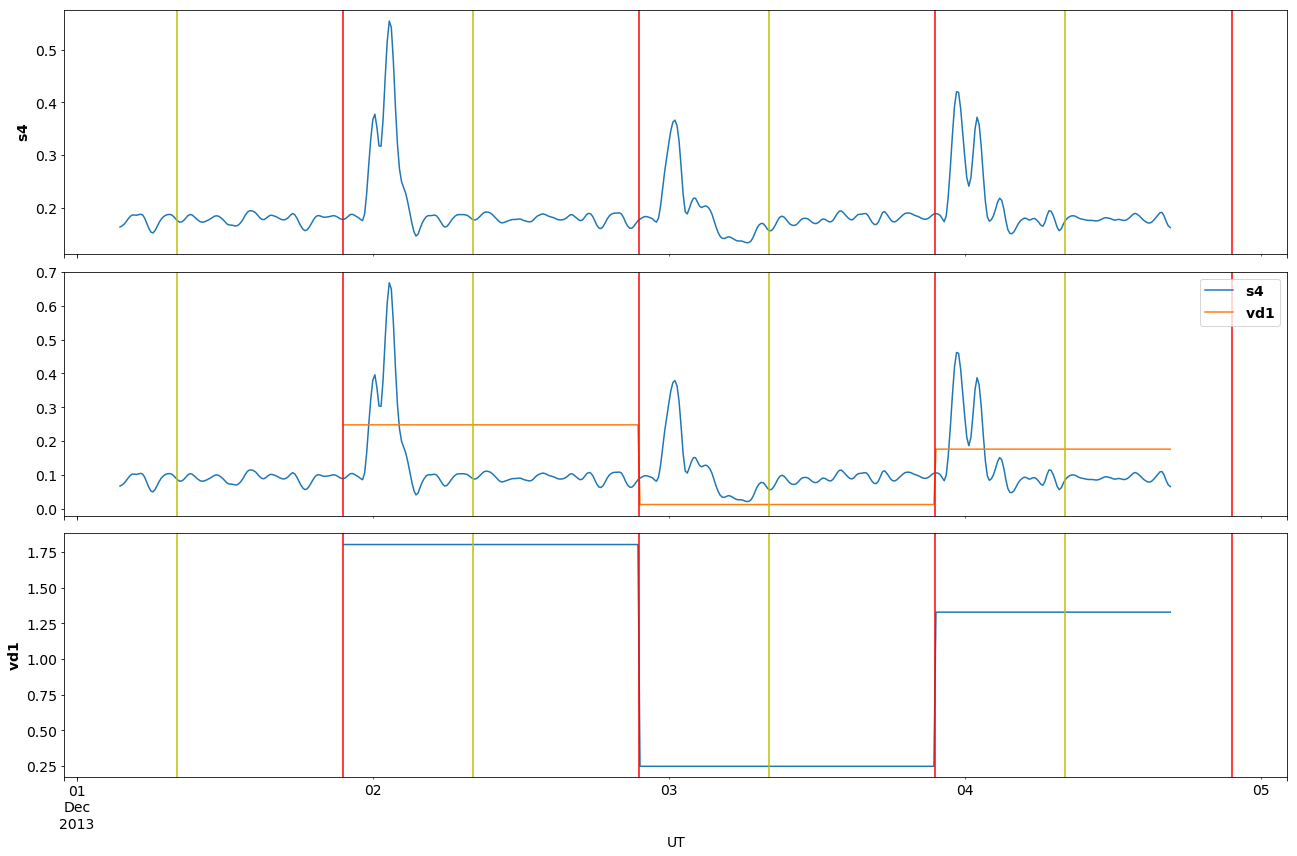

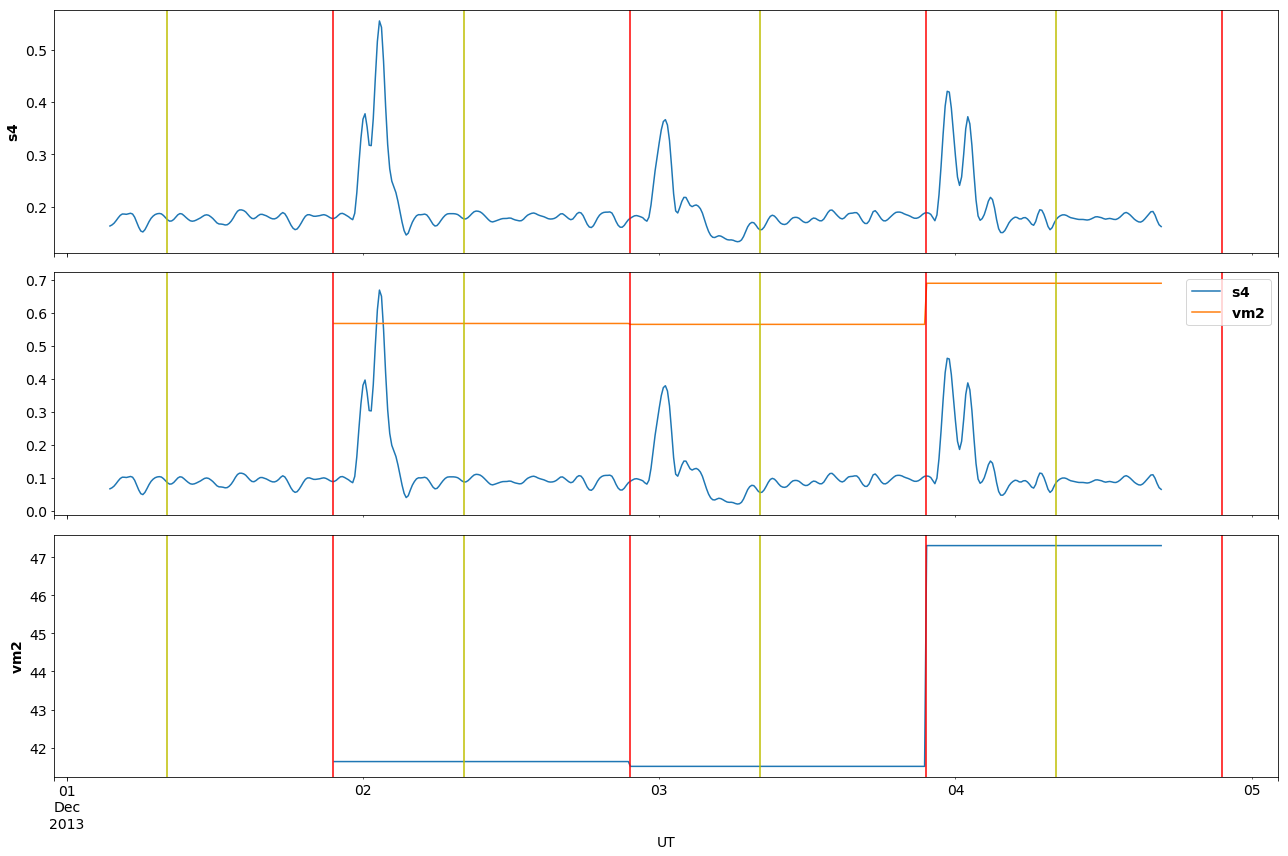

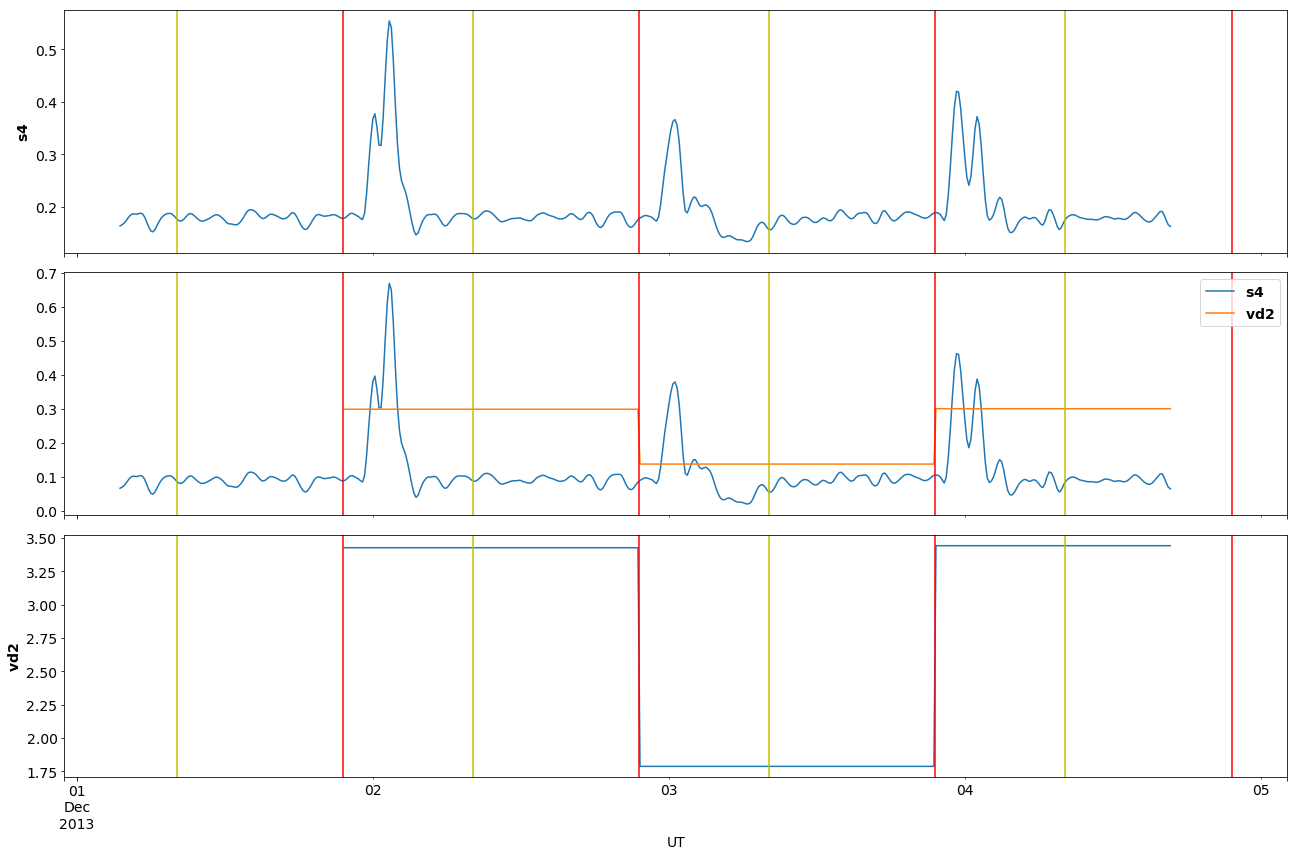

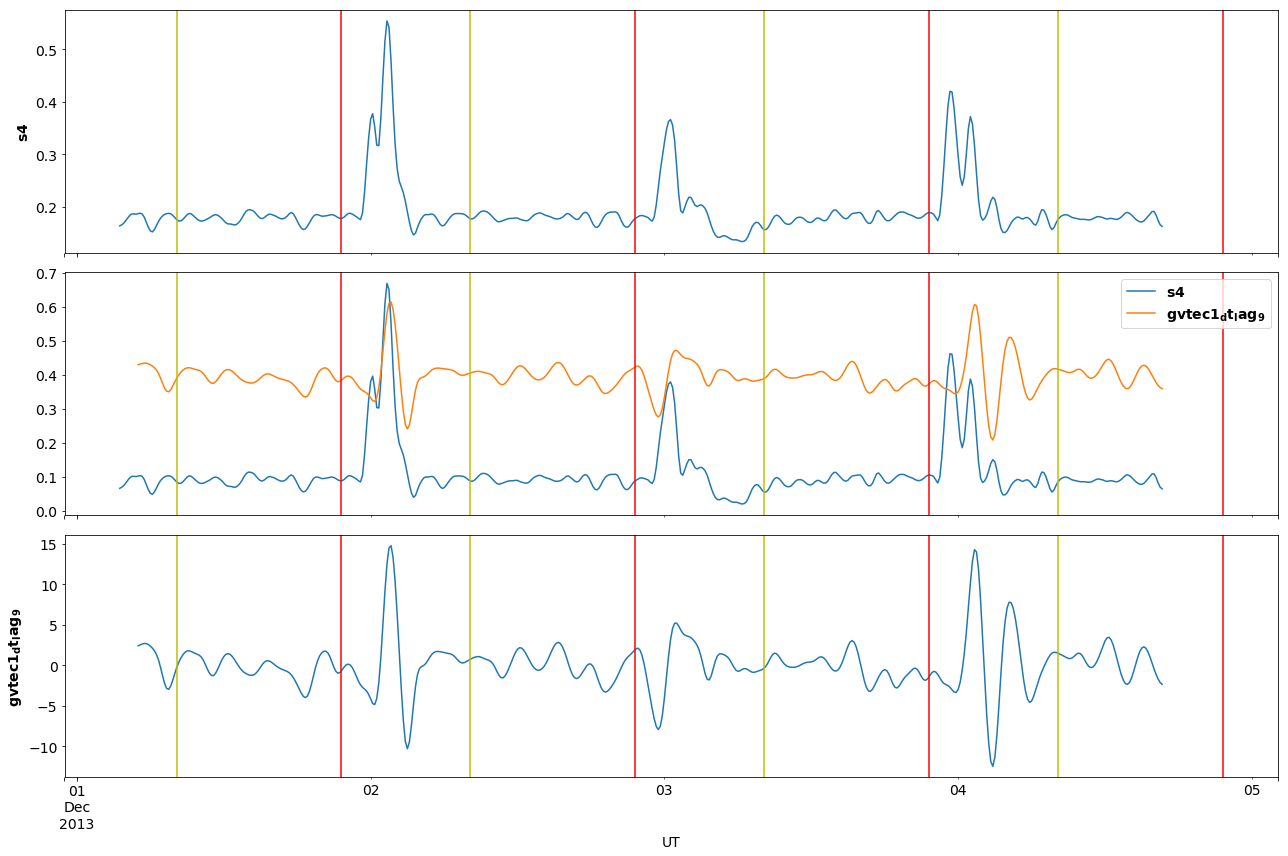

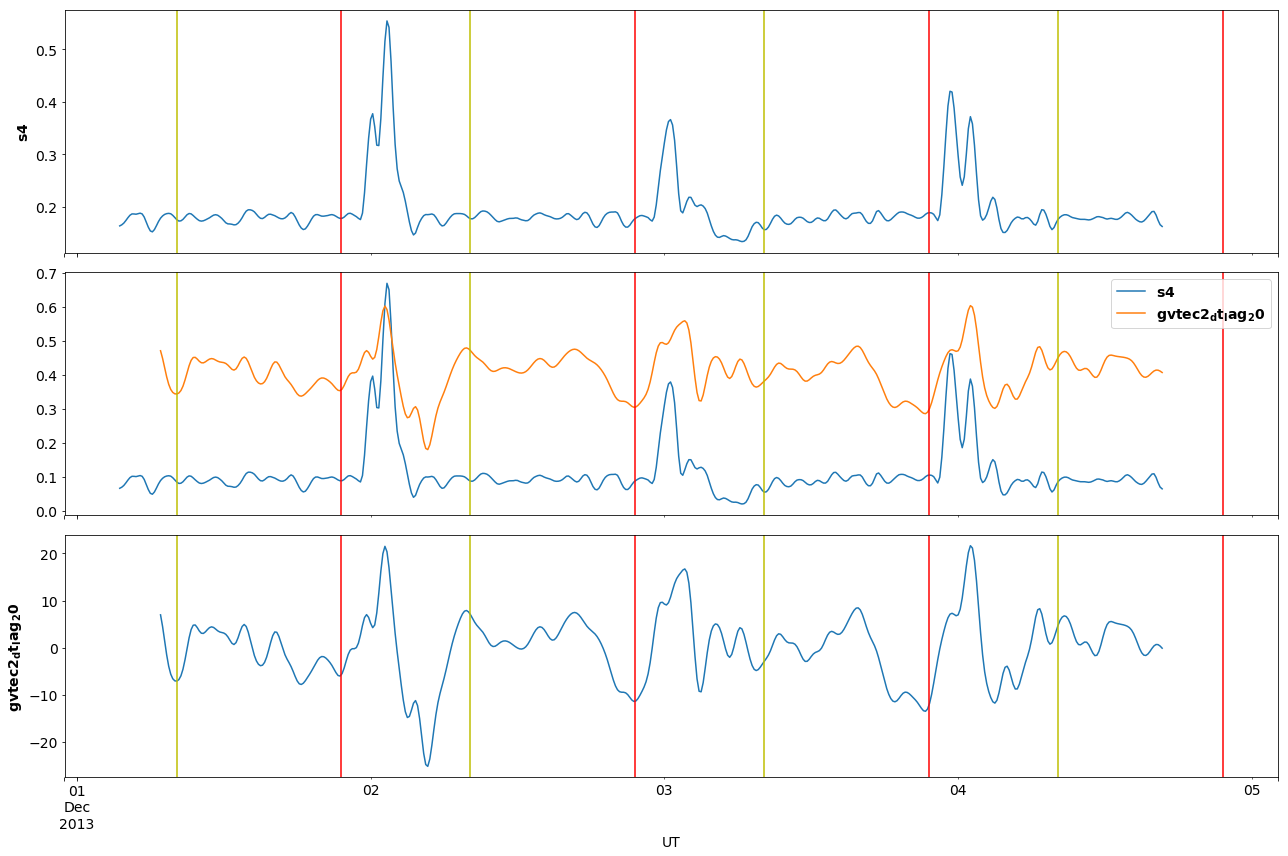

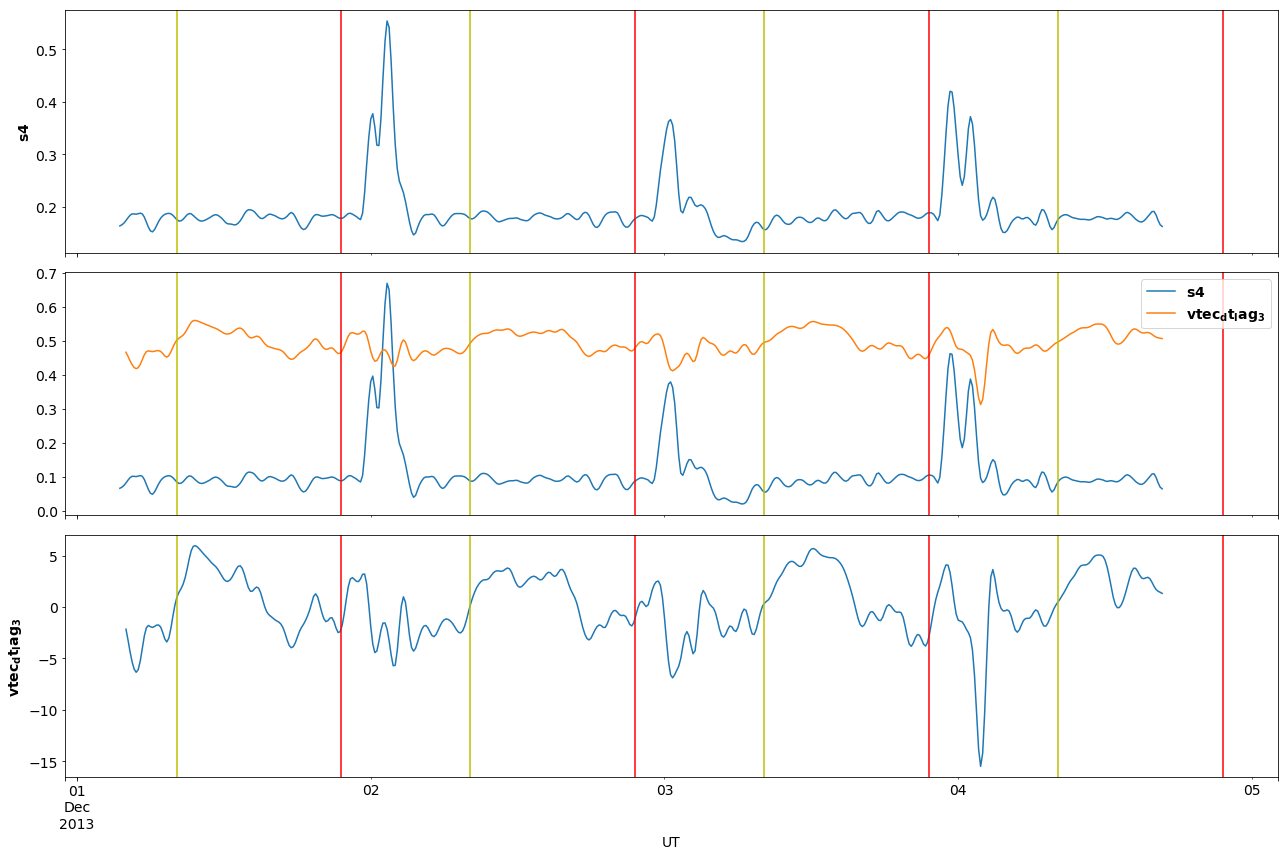

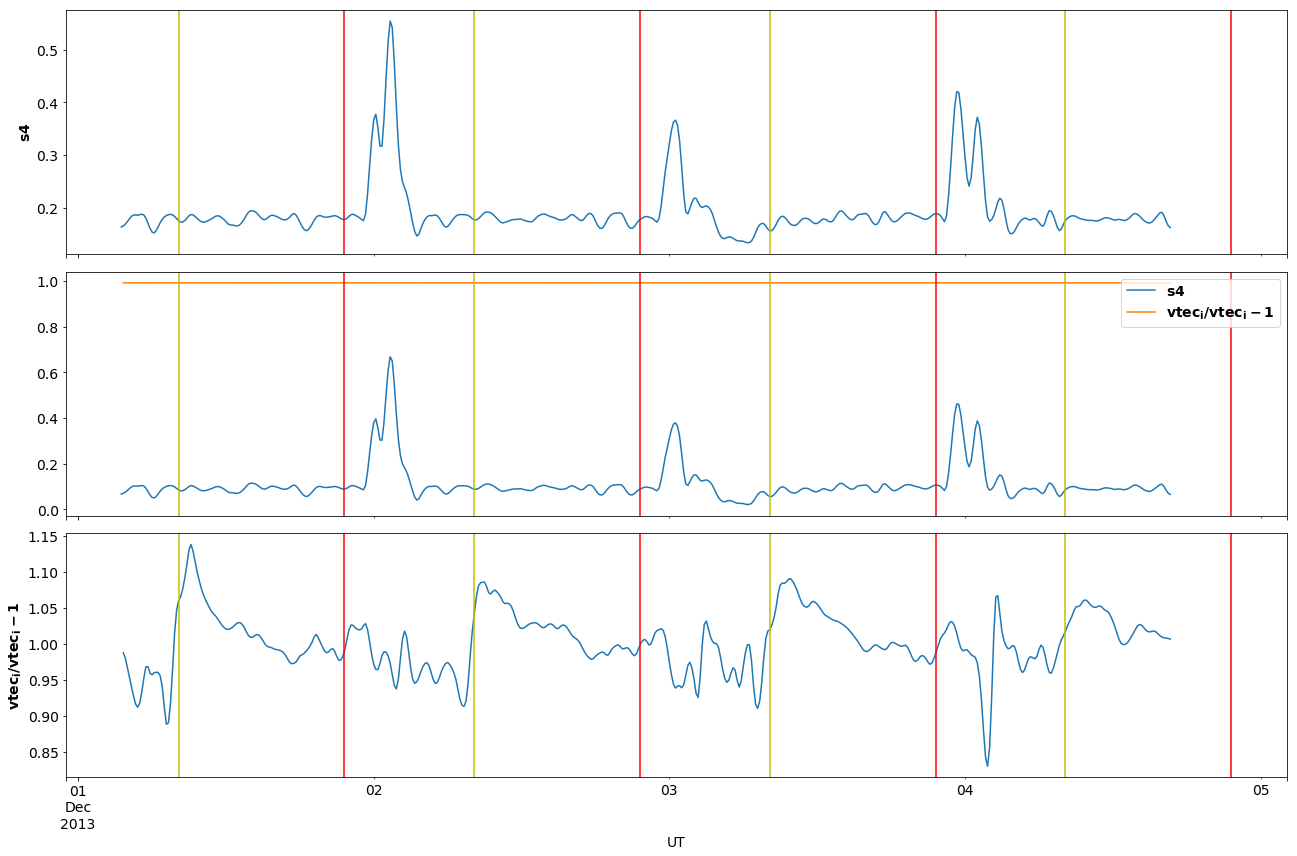

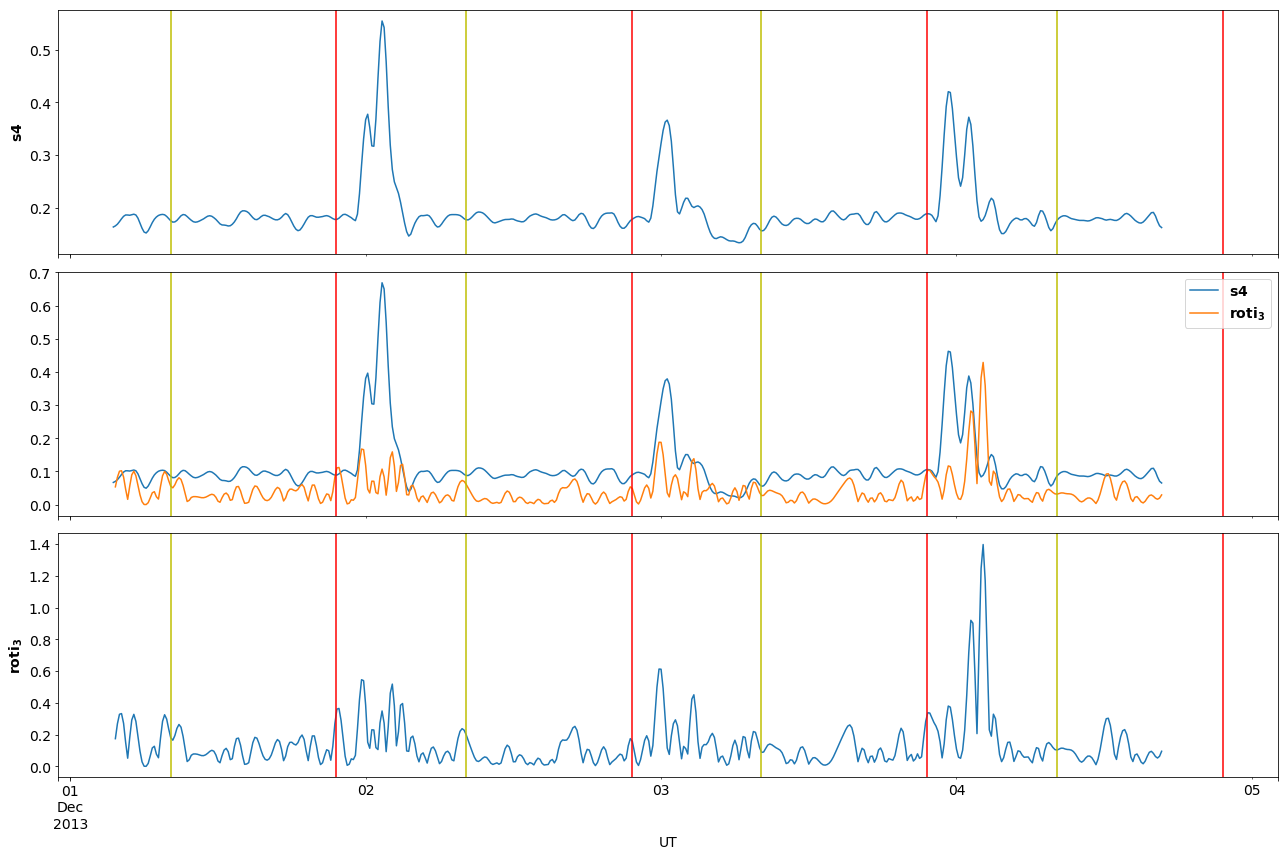

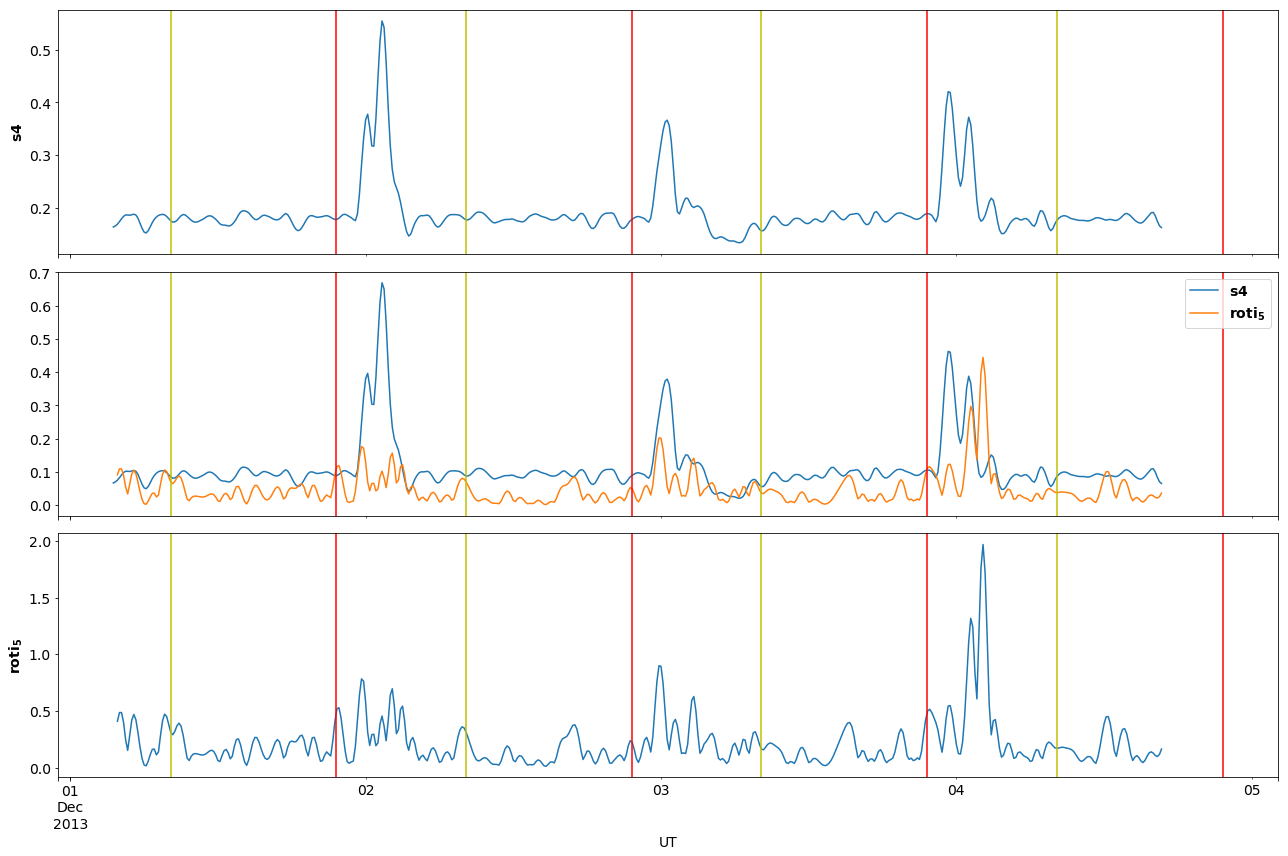

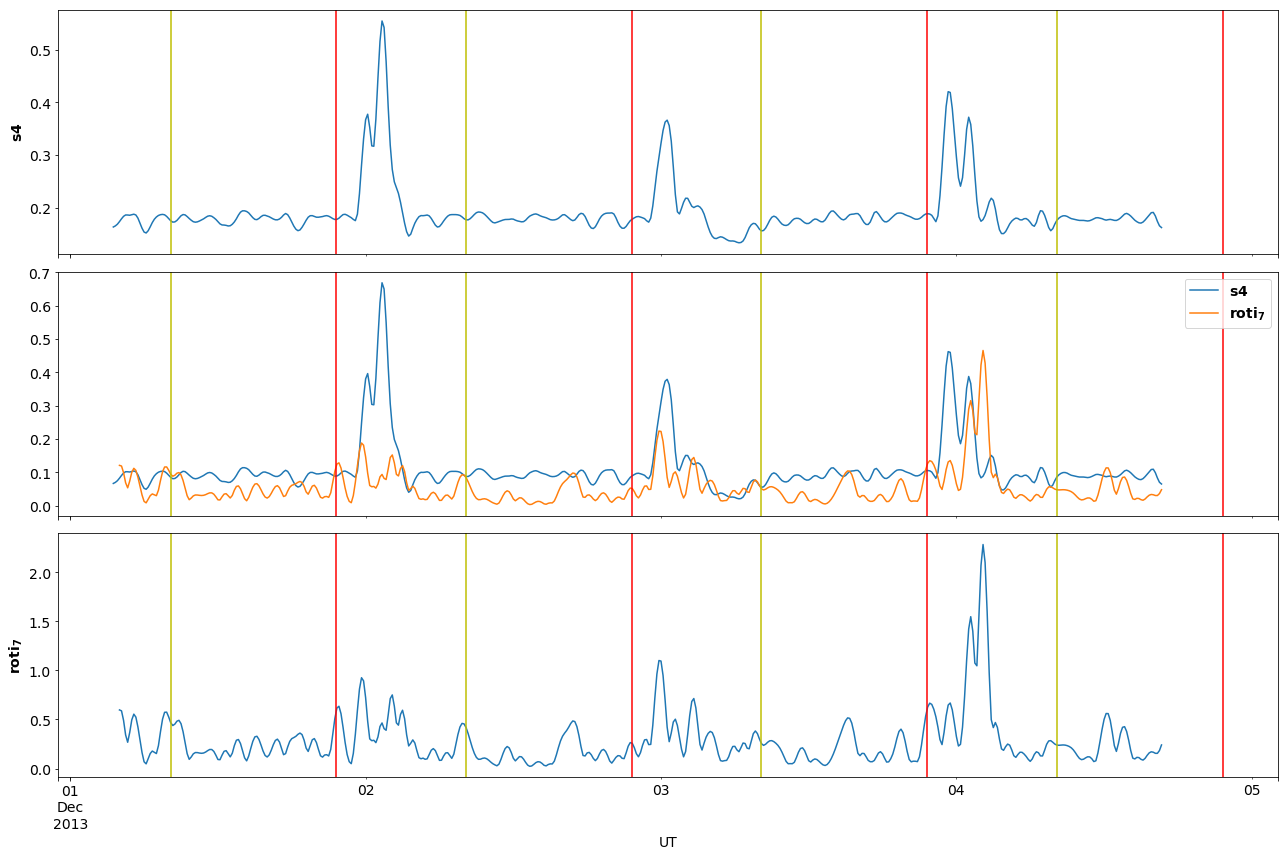

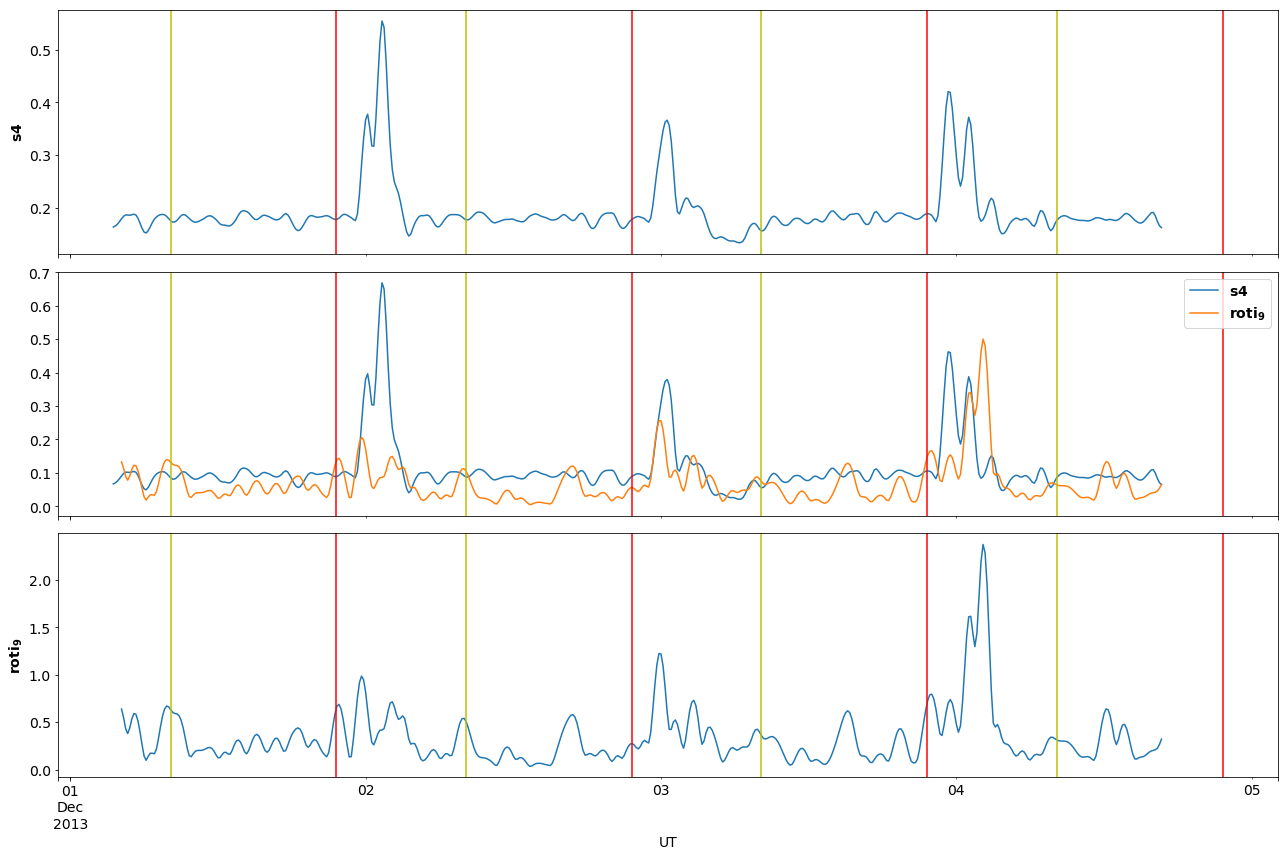

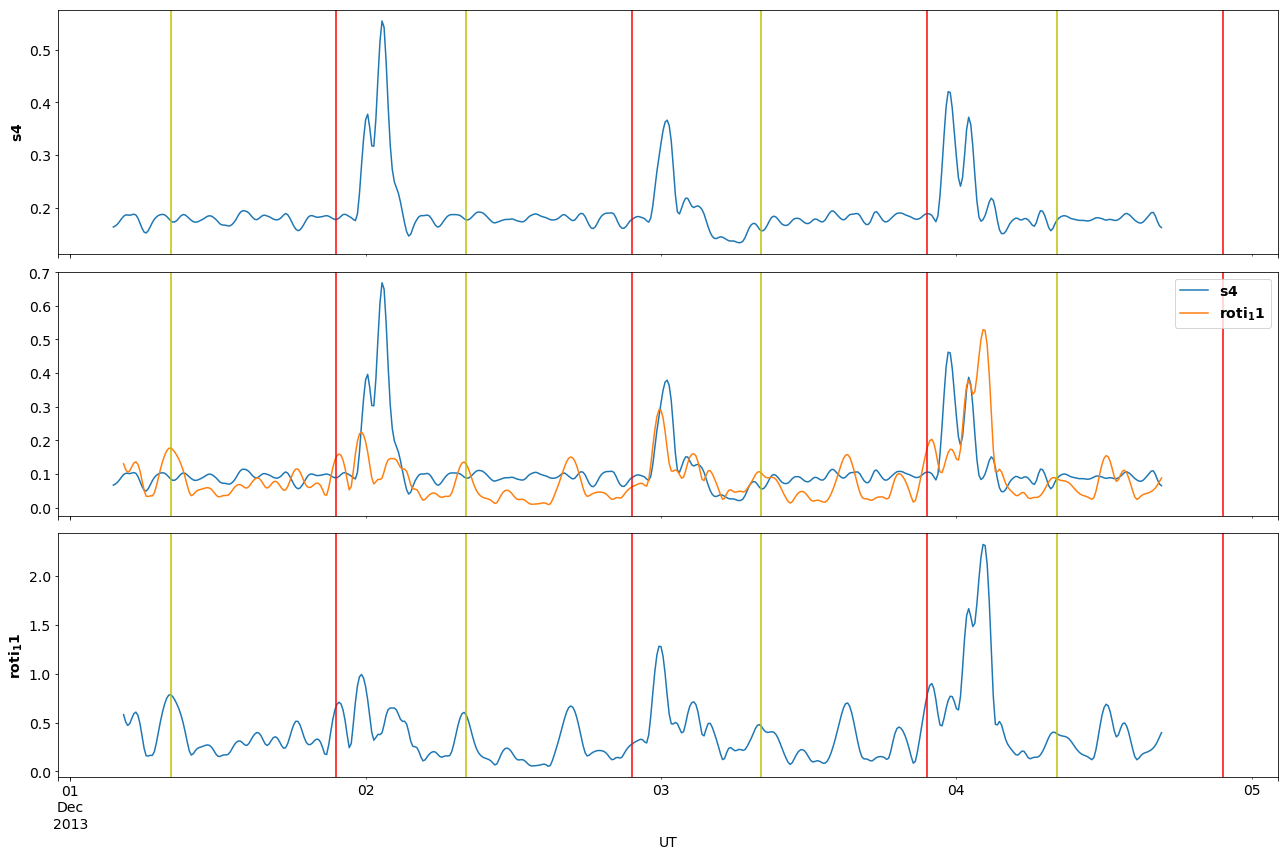

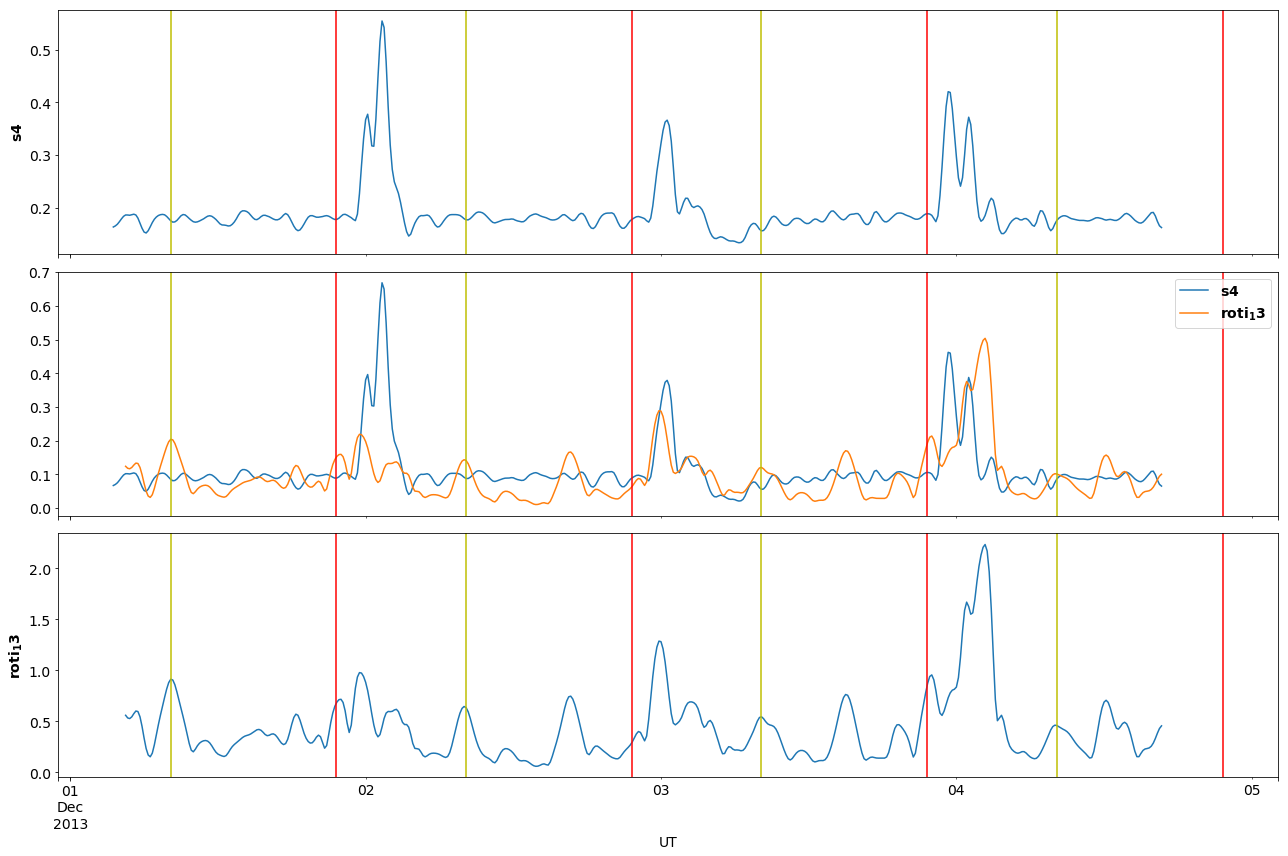

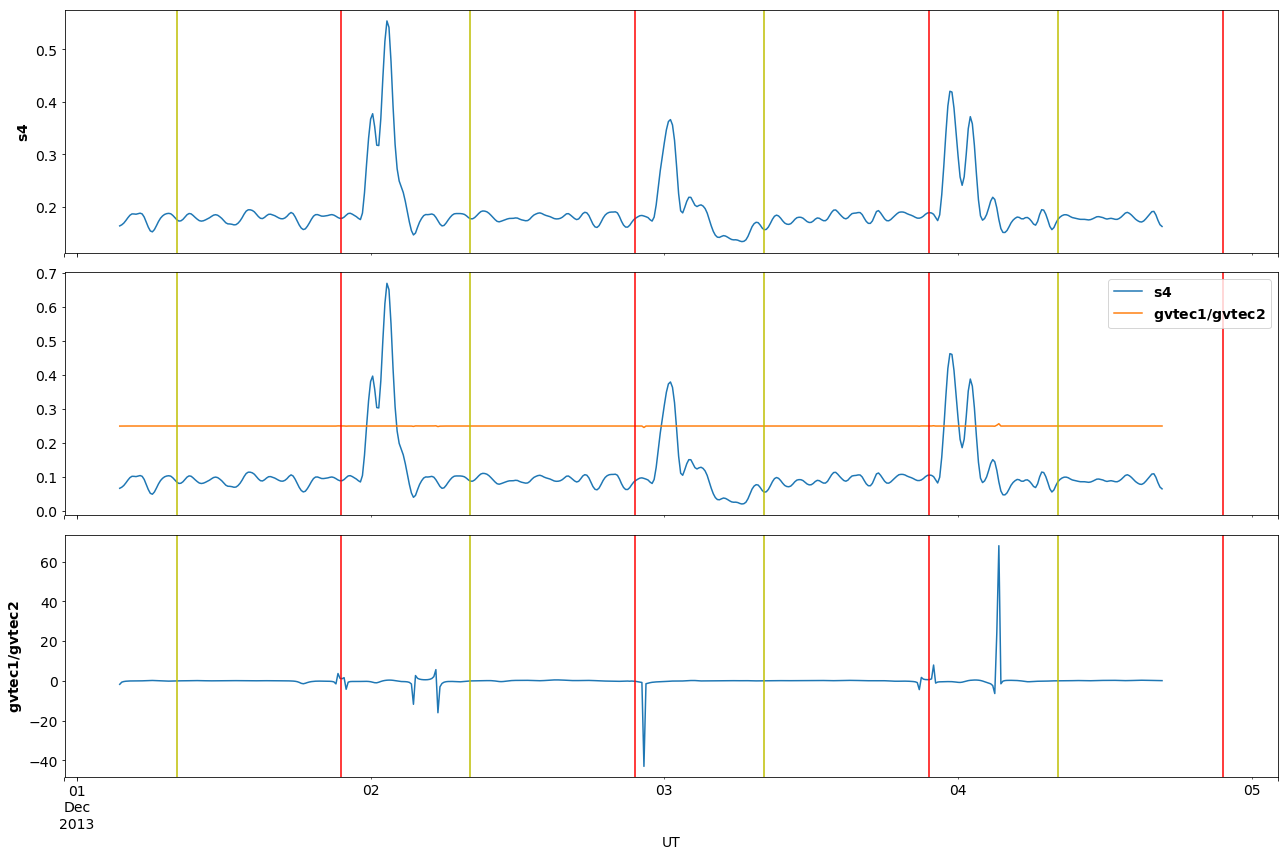

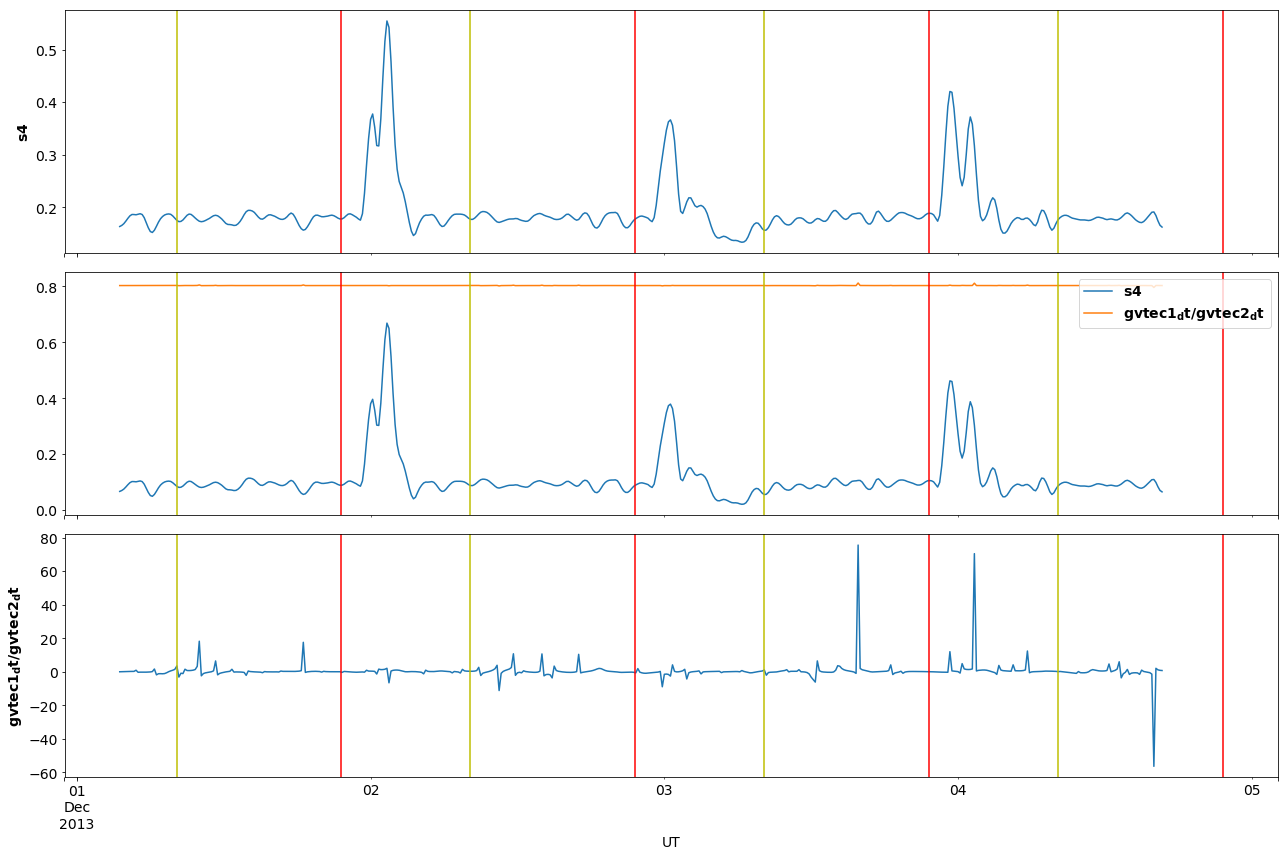

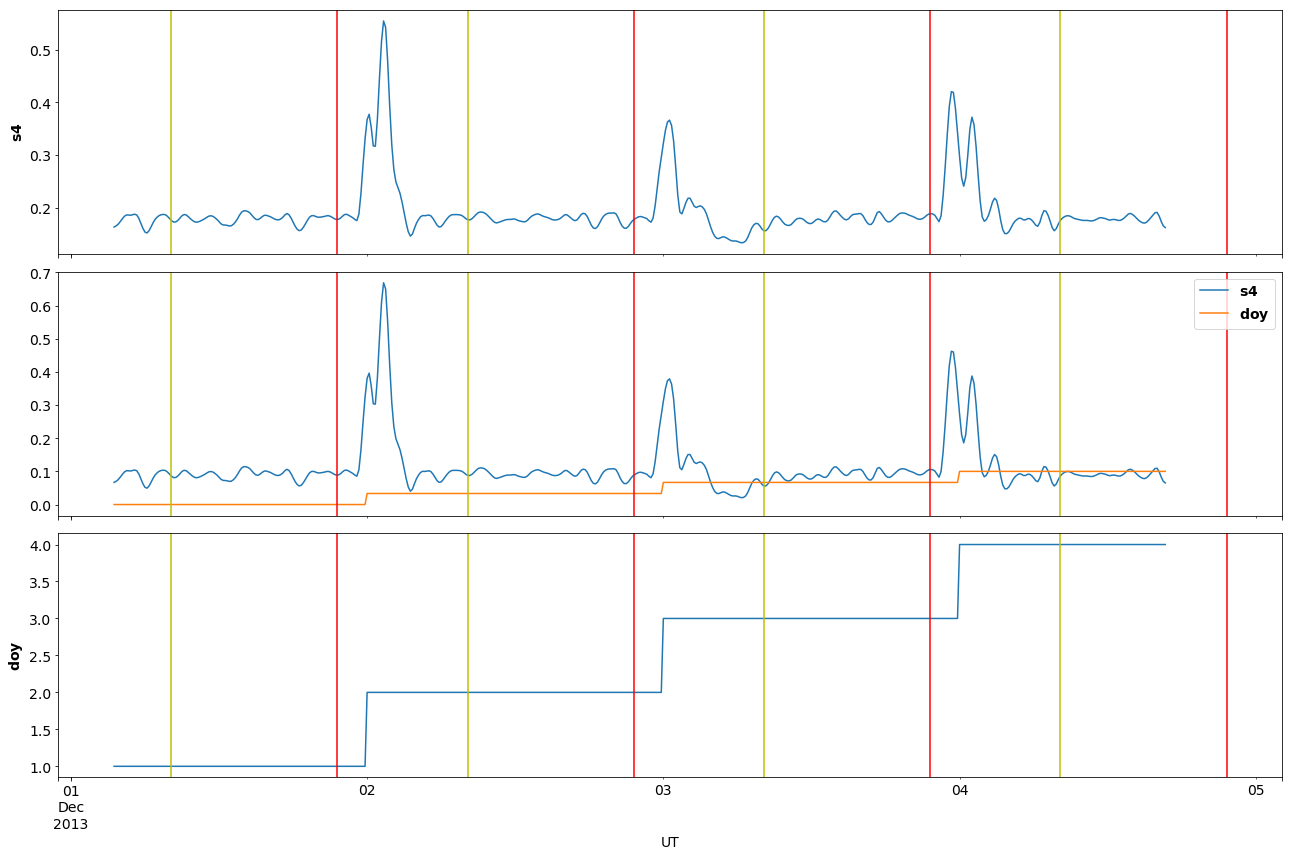

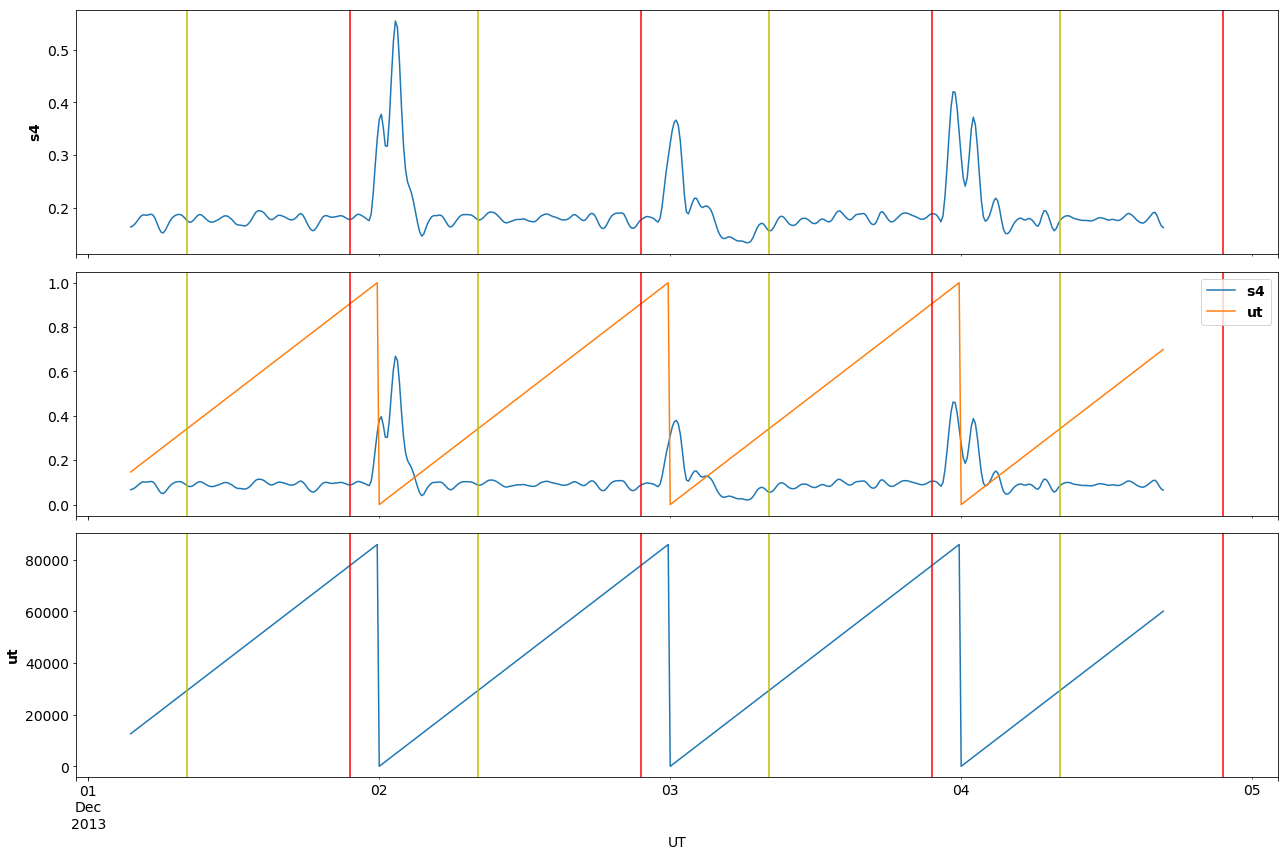

In [12]:
a = 0
b = 512

for i in df.columns:
    fig, ax = plt.subplots(3, 1, sharex=True)
    figsize=(18, 12)
    df['s4'][a:b].plot(figsize=figsize, ax=ax[0])
    df[i][a:b].plot(figsize=figsize, ax=ax[2])

    scale_first = Scale(df['s4'].min(), df['s4'].max())
    first_scale = pd.Series(scale_first(df['s4'].values), index=df.index.values)

    scale_i = Scale(df[i].min(), df[i].max())
    i_scale = pd.Series(scale_i(df[i].values), index=df.index.values)

    first_scale[a:b].plot(figsize=figsize, ax=ax[1], label=r"$\bf s4$") 
    i_scale[a:b].plot(figsize=figsize, ax=ax[1], label=r"$\bf %s$" % i)
    ax[1].legend(loc="upper right")

    ax[0].set(ylabel=r"$\bf s4$")
    ax[2].set(ylabel=r"$\bf %s$" % i)
    ax[2].set(xlabel=r"UT")

    plot_sunrise_and_sunset('sj2', df[a:b], ax)

    fig.tight_layout()

In [13]:
df = df.dropna()

# drop day, continue with just night
df = df[df['state_day'] == 0.0]
if 'state_day' in df.columns.values:
    df = df.drop('state_day', axis=1)

df.to_pickle('./data/sj2_analise_update2_drop.pkl')
df.to_csv('./data/sj2_analise_update2_drop.csv')

In [14]:
X = df[['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2',
       'gvtec2_dt', 'state_night', 'state_dawn',
       'state_day_shift', 'vm1', 'vd1', 'vm2', 'vd2', 'gvtec1_dt_lag_9',
       'gvtec2_dt_lag_20', 'vtec_dt_lag_3', 'vtec_i/vtec_i-1', 'roti_3',
       'roti_5', 'roti_7', 'roti_9', 'roti_11', 'roti_13', 'gvtec1/gvtec2',
       'gvtec1_dt/gvtec2_dt', 'doy', 'ut']]
y = df['s4']

In [15]:
for i, value in zip(df.columns, f_regression(X, y)[0]):
    print(i, value)

vtec 1143.170977709627
vtec_dt 0.05550065979485928
vtec_dt2 64.48568931963895
gvtec1 516.7041032959321
gvtec1_dt 113.5406180660882
gvtec2 5.780653442213252
gvtec2_dt 19.452127761403947
s4 41.29339078985903
state_night 41.29339078985894
state_dawn 8.586189950640351
state_day_shift 135.38342745259087
vm1 22.10851957677874
vd1 161.38800169342954
vm2 5.758065948069612
vd2 1.8685000952250335
gvtec1_dt_lag_9 7.165693304210881
gvtec2_dt_lag_20 9.421441668554955
vtec_dt_lag_3 2.5160785484782684
vtec_i/vtec_i-1 1087.7328172852488
roti_3 1205.3141594623125
roti_5 1255.6202740361869
roti_7 1236.1920400052309
roti_9 1175.5542824498616
roti_11 1108.9081942379726
roti_13 0.9023000164530941
gvtec1/gvtec2 0.6185334197801863
gvtec1_dt/gvtec2_dt 18.203421978955415
doy 7.67941744647236


In [16]:
for i, value in zip(df.columns, mutual_info_regression(X, y)):
    print(i, value)

vtec 0.23427259281868107
vtec_dt 0.061695987946506214
vtec_dt2 0.08947768590944971
gvtec1 0.09254720246353898
gvtec1_dt 0.07550481532727904
gvtec2 0.09407630004593859
gvtec2_dt 0.08268772539877656
s4 0.040492867790971054
state_night 0.040492867790971054
state_dawn 0.0104778289391112
state_day_shift 0.28375412209583395
vm1 0.2957472893603166
vd1 0.2884037570228051
vm2 0.27061604831849273
vd2 0.0638826163811892
gvtec1_dt_lag_9 0.05908443725563561
gvtec2_dt_lag_20 0.06321781589034448
vtec_dt_lag_3 0.05885539586085553
vtec_i/vtec_i-1 0.08820551020862855
roti_3 0.08288090158824879
roti_5 0.08663334838210712
roti_7 0.10922821264748084
roti_9 0.10713443152918867
roti_11 0.10277635980187583
roti_13 0.020812028864785947
gvtec1/gvtec2 0.01164556779042103
gvtec1_dt/gvtec2_dt 0.16956206852446876
doy 0.3118309447997296


In [17]:
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(X, y)
for i, value in zip(df.columns, clf.feature_importances_):
    print(i, value)

vtec 0.11936422777367038
vtec_dt 0.012818019553598667
vtec_dt2 0.01549970692704269
gvtec1 0.03807346514220794
gvtec1_dt 0.031112925144055222
gvtec2 0.06513915637550777
gvtec2_dt 0.030192513009451635
s4 0.009121649686807311
state_night 0.010491775209258631
state_dawn 8.855517007204524e-05
state_day_shift 0.03363982486932074
vm1 0.05326791695828972
vd1 0.038941222633103
vm2 0.04259263481897957
vd2 0.025830509312264452
gvtec1_dt_lag_9 0.05194929428038222
gvtec2_dt_lag_20 0.011117639031062361
vtec_dt_lag_3 0.01133482525020573
vtec_i/vtec_i-1 0.016211147756378698
roti_3 0.015482199378971915
roti_5 0.023998076623106962
roti_7 0.03681078462371537
roti_9 0.03914490551121597
roti_11 0.03194532500467836
roti_13 0.012767010689418028
gvtec1/gvtec2 0.007930900199981009
gvtec1_dt/gvtec2_dt 0.060937270259185265
doy 0.1541965188080683
